# scorecardpipeline

## 引言

作为一名金融搬砖工作者，评分卡建模怎么也算是基操。本文主要对笔者日常使用的评分卡建模代码进行讲解，说明如何一步步从原始数据到最终评分卡模型以及如何解读产出的模型报告文档。

`scorecardpipeline` 封装了 `toad`、`scorecardpy`、`optbinning` 等评分卡建模相关组件，`API` 风格与 `sklearn` 高度一致，支持 `pipeline` 式端到端评分卡建模、模型报告输出、导出 `PMML` 文件、超参数搜索等功能，各位看官按需取用，用完记得顺带给个star以鼓励笔者继续开源相关工作。


|  微信 |  微信公众号 |
| :---: | :----: |
| <img src="https://itlubber.art//upload/itlubber.png" alt="itlubber.png" width="50%" border=0/> | <img src="https://itlubber.art//upload/itlubber_art.png" alt="itlubber_art.png" width="50%" border=0/> |
|  itlubber  | itlubber_art |

## 项目说明

### 代码结构

`scorecardpipeline` 仓库下代码主要用于提供评分卡建模相关的组件，项目结构如下：

```base
>> tree
.
├── LICENSE                         # 开源协议
├── README.md                       # 相关说明文档
├── requirements.txt                # 相关依赖包
└── setup.py                        # 打包文件
├── examples                        # 演示样例
│   └── scorecard_samples.ipynb
└── scorecardpipeline               # scorecardpipeline 包文件
    ├── excel_writer.py             # 操作 excel 的公共方法
    ├── template.xlsx               # excel 模版文件
    ├── matplot_chinese.ttf         # 中文字体
    ├── processing.py               # 数据处理相关代码
    ├── model.py                    # 模型相关代码
    ├── logger.py                   # 日志打印方法
    └── utils.py                    # 公用方法
```

### 简要说明

+ `processing` 中提供了数据前处理相关的方法：特征筛选方法（`FeatureSelection`、`StepwiseSelection`）、变量分箱方法（`Combiner`）、变量证据权重转换方法（`WOETransformer`），方法继承`sklearn.base`中的`BaseEstimator`和`TransformerMixin`，能够支持构建`pipeline`和超参数搜索
+ `model`中提供了基于`sklearn.linear_model.LogisticRegression`实现的`ITLubberLogisticRegression`，同时重写了`toad.ScoreCard`，以支持模型相关内容的输出
+ `excel_writer` 中提供了操作 `excel` 的一系列公共方法，包含设置条件格式、设置列宽、设置数字格式、插入指定样式的内容（`insert_value2sheet`）、插入图片数据（`insert_pic2sheet`）、插入`dataframe`数据内容（`insert_df2sheet`）、保存`excel`文件（`save`）等方法


### `scorecardpipeline` 安装

In [1]:
# !pip install -U scorecardpipeline -i https://pypi.Python.org/simple/
# !pip install -r /Users/lubberit/Desktop/workspace/scorecardpipeline/requirements.txt -U

## 快速开始

1 本地调试模式 [通过 pip 安装可直接跳过]

In [1]:
import sys
sys.path.append("../")

2 导入相关依赖文件

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scorecardpipeline as sp

In [3]:
sp

<module 'scorecardpipeline' from '/Users/lubberit/anaconda3/lib/python3.8/site-packages/scorecardpipeline/__init__.py'>

3 初始化环境

+ 去除python警告信息
+ 设置pandas显示列宽、浮点数显示精度
+ 设置matplotlib主题、中文字体支持
+ 固定随机种子[可选]
+ 日志打印[可选]

In [4]:
logger = sp.init_setting(seed=10, logger=True)

4 数据集准备

4.1 数据集读取

In [1]:
target = "target"
data = pd.read_pickle("/Users/lubberit/Downloads/360_DATA.pkl")

# target = "creditability"
# data = sp.germancredit()
# data[target] = data[target].map({"good": 0, "bad": 1})

# for col in data.columns.drop(target):
#     for i in range(len(data)):
#         if np.random.rand() > 0.8:
#             data[col].loc[i] = np.nan

data.head()

NameError: name 'pd' is not defined

In [5]:
train, test = train_test_split(data, test_size=0.3, shuffle=True, stratify=data[target])

logger.info(f"训练集数据: {train.shape}, 测试集数据: {test.shape}")

4.2 数据集概要信息

In [6]:
# 模拟实际场景中的数据， date 为数据集中的日期，为 datetime 类型，实际生产过程中可能是 申请时间｜放款时间｜入催时间｜流失时间 等

df = pd.DataFrame()
df["date"] = pd.date_range(start="2021-01-01", end="2021-06-30", freq="5H")
df[target] = np.random.randint(0, 2, len(df))

total_count = len(data)
dataset_summary = pd.DataFrame(
    [
        ["建模样本", "2022-01-01", "2023-01-31", len(data), len(data) / total_count, data[target].sum(), data[target].sum() / len(data), ""],
        ["训练集", "2022-01-01", "2023-12-31", len(train), len(train) / total_count, train[target].sum(), train[target].sum() / len(train), ""],
        ["测试集", "2022-01-01", "2023-12-31", len(test), len(test) / total_count, test[target].sum(), test[target].sum() / len(test), ""],
    ],
    columns=["数据集", "开始时间", "结束时间", "样本总数", "样本占比", "坏客户数", "坏客户占比", "备注"],
)

dataset_summary

数据集        开始时间        结束时间  样本总数  样本占比  坏客户数  坏客户占比 备注
0  建模样本  2022-01-01  2023-01-31  1000   1.0   300    0.3   
1   训练集  2022-01-01  2023-12-31   700   0.7   210    0.3   
2   测试集  2022-01-01  2023-12-31   300   0.3    90    0.3

In [7]:
sp.distribution_plot?

Signature:
sp.distribution_plot(
    data,
    date='date',
    target='target',
    save=None,
    figsize=(10, 6),
    colors=['#2639E9', '#F76E6C', '#FE7715'],
    freq='M',
    anchor=0.94,
    result=False,
    hatch=True,
)
Docstring: <no docstring>
File:      ~/anaconda3/lib/python3.8/site-packages/scorecardpipeline/utils.py
Type:      function

In [8]:
sp.distribution_plot(data, date="申请时间", target=target)

KeyError: '申请时间'

5 数据预处理

5.1 特征粗筛选[可选]

+ 根据特征重要性进行筛选

使用 `catboost` 在数据集上训练后的 `feature_importances_` 进行排序，选出 `top_k` 个较为重要的特征，如果需要排除高 `iv` 值的变量，可以通过 `max_iv` 先筛选特征后再通过 `catboost` 进行筛选

In [20]:
sp.FeatureImportanceSelector?

Init signature:
sp.FeatureImportanceSelector(
    top_k=126,
    target='target',
    selector='catboost',
    params=None,
    max_iv=None,
)
Docstring:     
Base class for all estimators in scikit-learn.

Notes
-----
All estimators should specify all the parameters that can be set
at the class level in their ``__init__`` as explicit keyword
arguments (no ``*args`` or ``**kwargs``).
Init docstring:
基于特征重要性的特征筛选方法

Args:
    target: 数据集中标签名称，默认 target
    top_k: 依据特征重要性进行排序，筛选最重要的 top_k 个特征
    max_iv: 是否需要删除 IV 过高的特征，建议设置为 1.0
    selector: 特征选择器，目前只支持 catboost ，可以支持数据集中包含字符串的数据
    params: selector 的参数，不传使用默认参数
File:           ~/anaconda3/lib/python3.8/site-packages/scorecardpipeline/processing.py
Type:           type
Subclasses:     

+ 常规特征筛选方法

通过封装 `toad` 和 `scorecardpy` 库中相应方法进行实现，补全了 `toad` 缺少 `identical` （即唯一值占比）的筛选方法

In [21]:
sp.FeatureSelection?

Init signature:
sp.FeatureSelection(
    target='target',
    empty=0.95,
    iv=0.02,
    corr=0.7,
    exclude=None,
    return_drop=True,
    identical=0.95,
    remove=None,
    engine='scorecardpy',
    target_rm=False,
)
Docstring:     
Mixin class for all transformers in scikit-learn.

If :term:`get_feature_names_out` is defined, then `BaseEstimator` will
automatically wrap `transform` and `fit_transform` to follow the `set_output`
API. See the :ref:`developer_api_set_output` for details.

:class:`base.OneToOneFeatureMixin` and
:class:`base.ClassNamePrefixFeaturesOutMixin` are helpful mixins for
defining :term:`get_feature_names_out`.
Init docstring:
ITLUBBER提供的特征筛选方法

Args:
    target: 数据集中标签名称，默认 target
    empty: 空值率，默认 0.95, 即空值占比超过 95% 的特征会被剔除
    iv: IV值，默认 0.02，即iv值小于 0.02 时特征会被剔除
    corr: 相关性，默认 0.7，即特征之间相关性大于 0.7 时会剔除iv较小的特征
    identical: 唯一值占比，默认 0.95，即当特征的某个值占比超过 95% 时，特征会被剔除
    engine: 特征筛选使用的引擎，可选 "toad", "scorecardpy" 两种，默认 scorecardpy
    remove: 引擎使用 scorecard

5.2 特征分箱

集成 `toad` 和 `optbinning` 的分箱方法，支持 `chi`、`dt`、`quantile`、`step`、`kmeans`、`cart`、`mdlp`、`uniform` 等分箱方法

In [22]:
sp.Combiner?

Init signature:
sp.Combiner(
    target='target',
    method='chi',
    empty_separate=False,
    min_n_bins=2,
    max_n_bins=None,
    max_n_prebins=20,
    min_prebin_size=0.02,
    min_bin_size=0.05,
    max_bin_size=None,
    gamma=0.01,
    monotonic_trend='auto_asc_desc',
    adj_rules={},
    n_jobs=1,
)
Docstring:     
Mixin class for all transformers in scikit-learn.

If :term:`get_feature_names_out` is defined, then `BaseEstimator` will
automatically wrap `transform` and `fit_transform` to follow the `set_output`
API. See the :ref:`developer_api_set_output` for details.

:class:`base.OneToOneFeatureMixin` and
:class:`base.ClassNamePrefixFeaturesOutMixin` are helpful mixins for
defining :term:`get_feature_names_out`.
Init docstring:
特征分箱封装方法

Args:
    target: 数据集中标签名称，默认 target
    method: 特征分箱方法，可选 "chi", "dt", "quantile", "step", "kmeans", "cart", "mdlp", "uniform", 参考 toad.Combiner & optbinning.OptimalBinning
    empty_separate: 是否空值单独一箱, 默认 False，推荐设置为 True
    min_n_bin

5.3 `WOE` 编码

In [23]:
sp.WOETransformer?

Init signature: sp.WOETransformer(target='target', exclude=None)
Docstring:     
Mixin class for all transformers in scikit-learn.

If :term:`get_feature_names_out` is defined, then `BaseEstimator` will
automatically wrap `transform` and `fit_transform` to follow the `set_output`
API. See the :ref:`developer_api_set_output` for details.

:class:`base.OneToOneFeatureMixin` and
:class:`base.ClassNamePrefixFeaturesOutMixin` are helpful mixins for
defining :term:`get_feature_names_out`.
Init docstring:
WOE转换器

Args:
    target: 数据集中标签名称，默认 target
    exclude: 不需要转换 woe 的列
File:           ~/anaconda3/lib/python3.8/site-packages/scorecardpipeline/processing.py
Type:           type
Subclasses:     

5.4 特征精筛[可选]

通常特征分箱转 `woe` 编码后，特征之间的相关性会增加，变量 `iv` 指标可能有一定的下降，为了避免多重共线性以及无效变量入模，会在 `woe` 编码后在筛选一次变量，筛选方法参考 `5.1` 中的 `sp.FeatureSelection` 使用方法，

5.5 逐步回归筛选[可选]

逐步回归是以线性回归为基础的方法。其思路是将特征一个接着一个引入，并在引入一个新特征后，对已入选回归模型的旧特征逐个进行检验，将认为没有意义的特征删除，直到没有新特征引入也没有旧特征删除，从而保证回归模型中每一个特征都有意义（即统计意义上的显著）。在正式进行逻辑回归建模之前，增加一步逐步回归剔除特征，能够在一定程度上减少特征之间的多重共线性，同时也能保证逻辑回归具有更好的效果。

In [24]:
sp.StepwiseSelection?

Init signature:
sp.StepwiseSelection(
    target='target',
    estimator='ols',
    direction='both',
    criterion='aic',
    max_iter=None,
    return_drop=True,
    exclude=None,
    intercept=True,
    p_value_enter=0.2,
    p_remove=0.01,
    p_enter=0.01,
    target_rm=False,
)
Docstring:     
Mixin class for all transformers in scikit-learn.

If :term:`get_feature_names_out` is defined, then `BaseEstimator` will
automatically wrap `transform` and `fit_transform` to follow the `set_output`
API. See the :ref:`developer_api_set_output` for details.

:class:`base.OneToOneFeatureMixin` and
:class:`base.ClassNamePrefixFeaturesOutMixin` are helpful mixins for
defining :term:`get_feature_names_out`.
Init docstring:
逐步回归筛选方法

Args:
    target: 数据集中标签名称，默认 target
    estimator: 预估器，默认 ols，可选 "ols", "lr", "lasso", "ridge"，通常默认即可
    direction: 逐步回归方向，默认both，可选 "forward", "backward", "both"，通常默认即可
    criterion: 评价指标，默认 aic，可选 "aic", "bic", "ks", "auc"，通常默认即可
    max_iter: 最大迭代次数，sklearn中使用

5.6 数据预处理 `pipeline`

In [9]:
# 构建 pipeline
feature_pipeline = sp.Pipeline([
    ("preprocessing_select", sp.FeatureSelection(target=target, engine="scorecardpy")),
    ("combiner", sp.Combiner(target=target, min_bin_size=0.1)),
    ("transform", sp.WOETransformer(target=target)),
    ("processing_select", sp.FeatureSelection(target=target, engine="toad")),
    ("stepwise", sp.StepwiseSelection(target=target)),
])

feature_pipeline

Pipeline(steps=[('preprocessing_select',
                 FeatureSelection(target='creditability')),
                ('combiner',
                 Combiner(min_bin_size=0.1, target='creditability')),
                ('transform',
                 WOETransformer(exclude=[], target='creditability')),
                ('processing_select',
                 FeatureSelection(engine='toad', target='creditability')),
                ('stepwise', StepwiseSelection(target='creditability'))])

In [10]:
# 训练
feature_pipeline.fit(train)

# 转换
woe_train = feature_pipeline.transform(train)
woe_test = feature_pipeline.transform(test)

woe_train.head()

[INFO] filtering variables ...


installment_rate_in_percentage_of_disposable_income  credit_history  \
998                                           0.148354          0.059485   
535                                          -0.199690         -0.929194   
150                                          -0.199690          0.059485   
873                                           0.148354          0.059485   
261                                           0.148354          0.059485   

     duration_in_month   purpose   housing  savings_account_and_bonds  \
998           0.763916  0.221869  0.118560                  -0.087685   
535           0.002043  0.221869  0.466525                   0.387766   
150          -1.649443 -0.585517  0.118560                  -0.087685   
873          -0.281167  0.221869 -0.207014                  -0.917433   
261           0.002043 -0.585517  0.118560                   0.387766   

     property  other_installment_plans  present_employment_since  \
998  0.450416                -0.161969                  0.210390   
535  0.162119                -0.161969                  0.344669   
150  0.450416                 0.459532                 -0.280302   
873 -0.136904                -0.161969                 -0.219054   
261  0.162119                 0.127243                 -0.280302   

     credit_amount  telephone  status_of_existing_checking_account  \
998      -0.449590  -0.096309                             0.894926   
535      -0.449590   0.180819                            -0.081678   
150      -0.449590  -0.096309                            -1.274703   
873       0.206993   0.180819                            -1.274703   
261      -0.449590   0.180819                             0.894926   

     age_in_years  other_debtors_or_guarantors  creditability  
998      0.225760                    -0.109267              1  
535     -0.251314                    -0.109267              1  
150     -0.251314                    -0.109267              0  
873      0.225760                    -0.109267              0  
261      0.225760                     0.305701              0

In [29]:
feature_pipeline[2]["purpose"]

{'value': array([0, 1, 2]),
 'woe': array([-0.63637066,  0.13309727,  0.47957308])}

In [30]:
feature_pipeline[1]["purpose"]

array([list(['car (used)', 'others', 'retraining', 'radio/television', 'domestic appliances', 'repairs']),
       list(['business', 'furniture/equipment', 'nan']),
       list(['education', 'car (new)'])], dtype=object)

In [19]:
# 变量相关性
sp.corr_plot?

Signature:
sp.corr_plot(
    data,
    figure_size=(16, 8),
    fontsize=16,
    mask=False,
    save=None,
    annot=True,
    max_len=35,
    linewidths=0.1,
    fmt='.2f',
    step=11,
    linecolor='white',
    **kwargs,
)
Docstring: <no docstring>
File:      ~/Desktop/workspace/scorecardpipeline/scorecardpipeline/utils.py
Type:      function

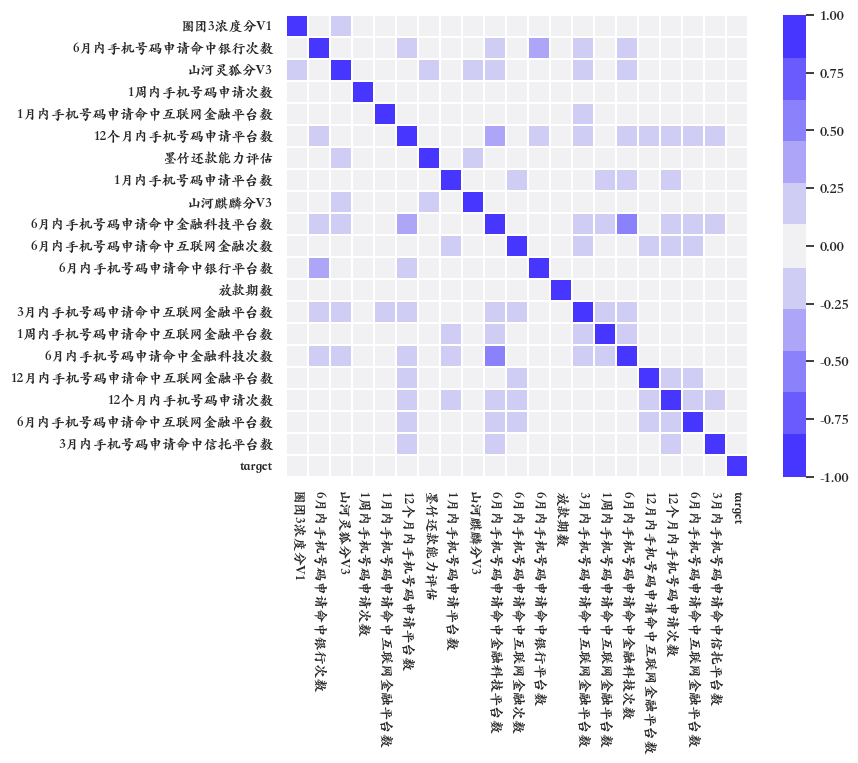

In [66]:
_ = sp.corr_plot(woe_train, annot=False, figure_size=(9, 6), max_len=25, fontsize=10)

6 逻辑回归模型训练

In [21]:
sp.ITLubberLogisticRegression?

Init signature:
sp.ITLubberLogisticRegression(
    target='target',
    penalty='l2',
    calculate_stats=True,
    dual=False,
    tol=0.0001,
    C=1.0,
    fit_intercept=True,
    intercept_scaling=1,
    class_weight=None,
    random_state=None,
    solver='lbfgs',
    max_iter=100,
    multi_class='auto',
    verbose=0,
    warm_start=False,
    n_jobs=None,
    l1_ratio=None,
)
Docstring:     
Extended Logistic Regression.
Extends [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
This class provides the following extra statistics, calculated on `.fit()` and accessible via `.summary()`:
- `cov_matrix_`: covariance matrix for the estimated parameters.
- `std_err_intercept_`: estimated uncertainty for the intercept
- `std_err_coef_`: estimated uncertainty for the coefficients
- `z_intercept_`: estimated z-statistic for the intercept
- `z_coef_`: estimated z-statistic for the coefficients
- `p_va

6.1 逻辑回归模型训练

In [22]:
# 逻辑回归模型构建
logistic = sp.ITLubberLogisticRegression(target=target)
logistic

ITLubberLogisticRegression()

In [23]:
# 训练
logistic.fit(woe_train)

# 预测
y_pred_train = logistic.predict_proba(woe_train.drop(columns=target))[:, 1]
y_pred_test = logistic.predict_proba(woe_test.drop(columns=target))[:, 1]

6.2 模型表现

In [24]:
# 模型 KS、AUC 指标
logger.info(f"dataset: train\t KS: {sp.KS(y_pred_train, train[target])},\t AUC: {sp.AUC(y_pred_train, train[target])}")
logger.info(f"dataset: test\t KS: {sp.KS(y_pred_test, test[target])},\t AUC: {sp.AUC(y_pred_test, test[target])}")

[ 2023-10-20 11:05:48,376 ][ INFO ][ 842722522.py:<module>:2 ] dataset: train	 KS: 0.7484669543493073,	 AUC: 0.906673480202892
[ 2023-10-20 11:05:48,379 ][ INFO ][ 842722522.py:<module>:3 ] dataset: test	 KS: 0.24567901234567902,	 AUC: 0.5509602194787381


In [25]:
# 模型拟合情况
logistic.summary()

Coef.  Std.Err        z  P>|z|  [ 0.025  0.975 ]    VIF
const                -3.7701   0.2196 -17.1673 0.0000  -4.2005  -3.3396 1.6852
圈团3浓度分V1              0.8504   0.2918   2.9145 0.0036   0.2785   1.4223 1.0320
6月内手机号码申请命中银行次数       1.1273   0.4831   2.3337 0.0196   0.1805   2.0742 1.2494
山河灵狐分V3               0.9037   1.0023   0.9017 0.3672  -1.0607   2.8682 1.0929
1周内手机号码申请次数           0.6645   0.4574   1.4530 0.1462  -0.2319   1.5610 1.0285
1月内手机号码申请命中互联网金融平台数   0.6661   0.4013   1.6600 0.0969  -0.1204   1.4527 1.0761
12个月内手机号码申请平台数        0.6807   0.4229   1.6096 0.1075  -0.1482   1.5097 1.2343
墨竹还款能力评估              0.3638   0.4224   0.8613 0.3891  -0.4641   1.1917 1.0410
1月内手机号码申请平台数          0.4327   0.3264   1.3256 0.1850  -0.2071   1.0725 1.0533
山河麒麟分V3               0.7450   0.3993   1.8660 0.0620  -0.0375   1.5276 1.0543
6月内手机号码申请命中金融科技平台数    0.1487   0.3416   0.4353 0.6634  -0.5208   0.8182 1.5573
6月内手机号码申请命中互联网金融次数    0.5746   0.3667   1.5669 0.1171  -0.1442   1.2934 1.0838
6月内手机号码申请命中银行平台数      0.7841   0.5427   1.4448 0.1485  -0.2796   1.8477 1.2084
放款期数                  0.7655   0.5329   1.4365 0.1509  -0.2789   1.8099 1.0061
3月内手机号码申请命中互联网金融平台数   1.1613   0.4391   2.6446 0.0082   0.3006   2.0220 1.1604
1周内手机号码申请命中互联网金融平台数   0.6060   1.0660   0.5685 0.5697  -1.4834   2.6954 1.0869
6月内手机号码申请命中金融科技次数     1.0044   0.6162   1.6299 0.1031  -0.2034   2.2123 1.3882
12月内手机号码申请命中互联网金融平台数  0.7927   0.3750   2.1136 0.0346   0.0576   1.5278 1.0633
12个月内手机号码申请次数         0.3510   0.3015   1.1641 0.2444  -0.2400   0.9420 1.1628
6月内手机号码申请命中互联网金融平台数   0.5403   0.4103   1.3169 0.1879  -0.2638   1.3445 1.0685
3月内手机号码申请命中信托平台数      0.9280   1.0308   0.9003 0.3680  -1.0924   2.9485 1.0564

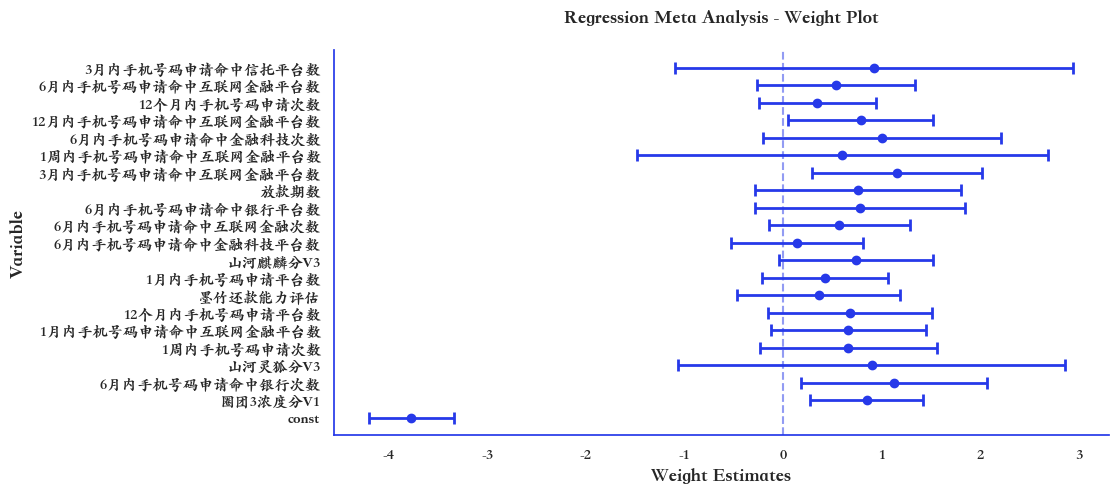

In [26]:
_ = logistic.plot_weights(figsize=(10, 5))

In [27]:
# 模型报告
logistic.report(woe_train)

desc precision recall  f1-score   support
0           好客户    0.9782 1.0000    0.9890 1887.0000
1           坏客户    0.0000 0.0000    0.0000   42.0000
2     macro avg    0.4891 0.5000    0.4945 1929.0000
3  weighted avg    0.9569 0.9782    0.9675 1929.0000
4      accuracy                     0.9782 1929.0000

In [28]:
# 模型报告
logistic.report(woe_test)

desc precision recall  f1-score  support
0           好客户    0.9783 1.0000    0.9890 810.0000
1           坏客户    0.0000 0.0000    0.0000  18.0000
2     macro avg    0.4891 0.5000    0.4945 828.0000
3  weighted avg    0.9570 0.9783    0.9675 828.0000
4      accuracy                     0.9783 828.0000

In [29]:
# 模型 KS、ROC 曲线
sp.ks_plot?

Signature:
sp.ks_plot(
    score,
    target,
    title='',
    fontsize=14,
    figsize=(16, 8),
    save=None,
    colors=['#2639E9', '#F76E6C', '#FE7715'],
    anchor=0.945,
)
Docstring: <no docstring>
File:      ~/Desktop/workspace/scorecardpipeline/scorecardpipeline/utils.py
Type:      function

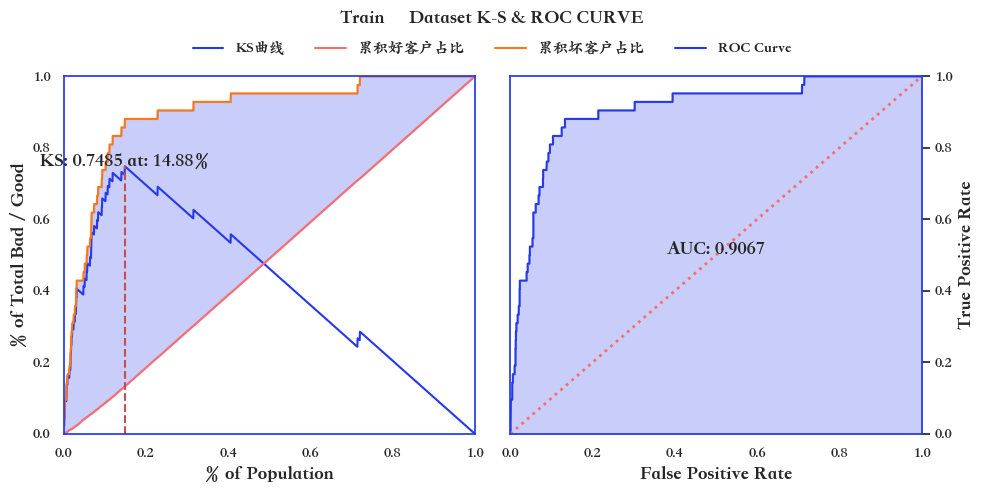

In [30]:
_ = sp.ks_plot(y_pred_train, train[target], figsize=(10, 5), title="Train \tDataset")

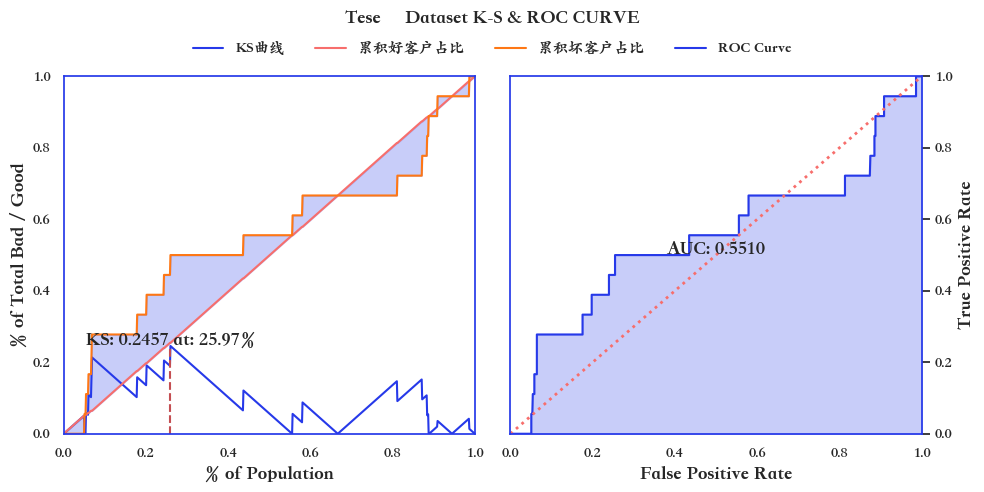

In [31]:
_ = sp.ks_plot(y_pred_test, test[target], figsize=(10, 5), title="Tese \tDataset")

In [32]:
# 概率分布图
sp.hist_plot?

Signature:
sp.hist_plot(
    score,
    y_true=None,
    figsize=(15, 10),
    bins=30,
    save=None,
    labels=['坏样本', '好样本'],
    anchor=1.1,
    fontsize=14,
    **kwargs,
)
Docstring: <no docstring>
File:      ~/Desktop/workspace/scorecardpipeline/scorecardpipeline/utils.py
Type:      function

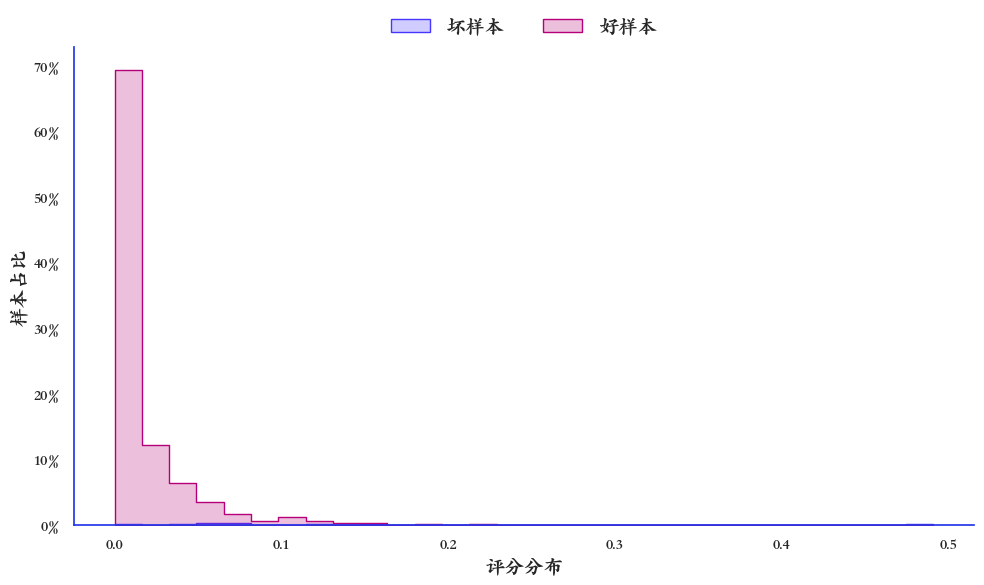

In [33]:
_ = sp.hist_plot(y_pred_train, train[target], figsize=(10, 6))

6.3 入模特征分箱图

In [34]:
# 特征分箱统计信息
sp.feature_bin_stats?

Signature:
sp.feature_bin_stats(
    data,
    feature,
    target='target',
    rules=None,
    method='step',
    desc='',
    combiner=None,
    ks=True,
    max_n_bins=None,
    min_bin_size=None,
    max_bin_size=None,
    empty_separate=True,
    return_cols=None,
    return_rules=False,
    verbose=0,
    **kwargs,
)
Docstring: <no docstring>
File:      ~/Desktop/workspace/scorecardpipeline/scorecardpipeline/processing.py
Type:      method

In [35]:
# 特征分箱图
sp.bin_plot?

Signature:
sp.bin_plot(
    feature_table,
    desc='',
    figsize=(10, 6),
    colors=['#2639E9', '#F76E6C', '#FE7715'],
    save=None,
    anchor=0.935,
    max_len=35,
    hatch=True,
    ending='分箱图',
)
Docstring:
简单策略挖掘：特征分箱图

:param feature_table: 特征分箱的统计信息表，由 feature_bin_stats 运行得到
:param desc: 特征中文含义或者其他相关信息
:param figsize: 图像尺寸大小，传入一个tuple，默认 （10， 6）
:param colors: 图片主题颜色，默认即可
:param save: 图片保存路径
:param anchor: 图例在图中的位置，通常 0.95 左右，根据图片标题与图例之间的空隙自行调整即可
:param max_len: 分箱显示的最大长度，防止分类变量分箱过多文本过长导致图像显示区域很小，默认最长 35 个字符
:param hatch: 柱状图是否显示斜杠，默认显示

:return Figure
File:      ~/Desktop/workspace/scorecardpipeline/scorecardpipeline/utils.py
Type:      function

In [36]:
# 数据字段[可选]
feature_describe = pd.DataFrame([
    ["status_account", "支票账户状态"], ["duration", "借款周期"], ["credit_histor", "历史信用"], ["purpose", "借款目的"], ["amount", "信用额度"], ["svaing_account", "储蓄账户状态"], ["present_emp", "当前就业状态"], ["income_rate", "分期付款占可支配收入百分比"], ["personal_status", "性别与婚姻状态"], ["other_debtors", "他人担保信息"], ["residence_info", "现居住地"], ["property", "财产状态"], ["age", "年龄"], ["inst_plans", "其他分期情况"], ["housing", "房产状态"], ["num_credits", "信用卡数量"], ["job", "工作状态"], ["dependents", "赡养人数"], ["telephone", "电话号码注册情况"], ["foreign_worke", "是否有海外工作经历"],
], columns=["变量名称", "变量含义"])
feature_map = dict(zip(feature_describe["变量名称"], feature_describe["变量含义"]))

圈团3浓度分V1


指标名称      指标含义             分箱  样本总数   样本占比  好样本数  好样本占比  坏样本数  坏样本占比  \
0  圈团3浓度分V1  逻辑回归入模变量   [负无穷 , 20.0)   547 0.1984   539 0.1999     8 0.1333   
1  圈团3浓度分V1  逻辑回归入模变量  [20.0 , 22.0)   329 0.1193   317 0.1175    12 0.2000   
2  圈团3浓度分V1  逻辑回归入模变量  [22.0 , 29.0)  1562 0.5666  1535 0.5692    27 0.4500   
3  圈团3浓度分V1  逻辑回归入模变量   [29.0 , 正无穷)   319 0.1157   306 0.1135    13 0.2167   

    坏样本率  分档WOE值  分档IV值  指标IV值  LIFT值  累积LIFT值  累积好样本数  累积坏样本数   分档KS值  
0 0.0146  0.4047 0.0269 0.1655 0.6720   0.6720     539       8 -0.0665  
1 0.0365 -0.5316 0.0438 0.1655 1.6760   1.0491     856      20  0.0159  
2 0.0173  0.2349 0.0280 0.1655 0.7943   0.8858    2391      47 -0.1032  
3 0.0408 -0.6469 0.0668 0.1655 1.8726   1.0000    2697      60  0.0000

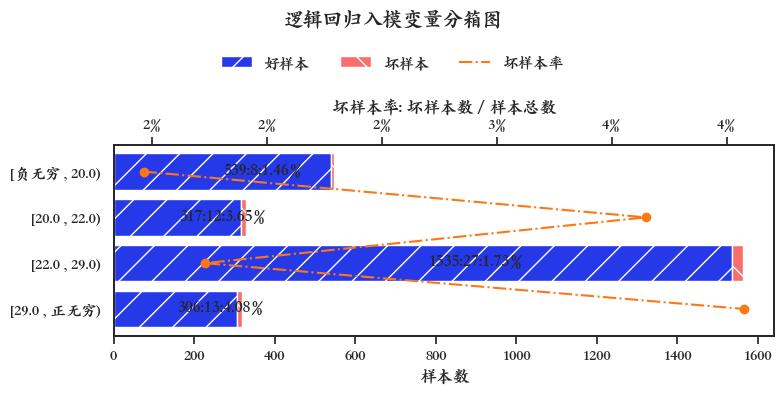

6月内手机号码申请命中银行次数


指标名称      指标含义           分箱  样本总数   样本占比  好样本数  好样本占比  坏样本数  \
0  6月内手机号码申请命中银行次数  逻辑回归入模变量  [负无穷 , 1.0)   684 0.2481   666 0.2469    18   
1  6月内手机号码申请命中银行次数  逻辑回归入模变量  [1.0 , 2.0)   509 0.1846   495 0.1835    14   
2  6月内手机号码申请命中银行次数  逻辑回归入模变量  [2.0 , 3.0)   362 0.1313   355 0.1316     7   
3  6月内手机号码申请命中银行次数  逻辑回归入模变量  [3.0 , 6.0)   678 0.2459   670 0.2484     8   
4  6月内手机号码申请命中银行次数  逻辑回归入模变量  [6.0 , 正无穷)   524 0.1901   511 0.1895    13   

   坏样本占比   坏样本率  分档WOE值  分档IV值  指标IV值  LIFT值  累积LIFT值  累积好样本数  累积坏样本数   分档KS值  
0 0.3000 0.0263 -0.1946 0.0103 0.0994 1.2092   1.2092     666      18  0.0531  
1 0.2333 0.0275 -0.2401 0.0120 0.0994 1.2639   1.2325    1161      32  0.1029  
2 0.1167 0.0193  0.1206 0.0018 0.0994 0.8885   1.1524    1516      39  0.0879  
3 0.1333 0.0118  0.6223 0.0716 0.0994 0.5422   0.9672    2186      47 -0.0272  
4 0.2167 0.0248 -0.1341 0.0036 0.0994 1.1400   1.0000    2697      60  0.0000

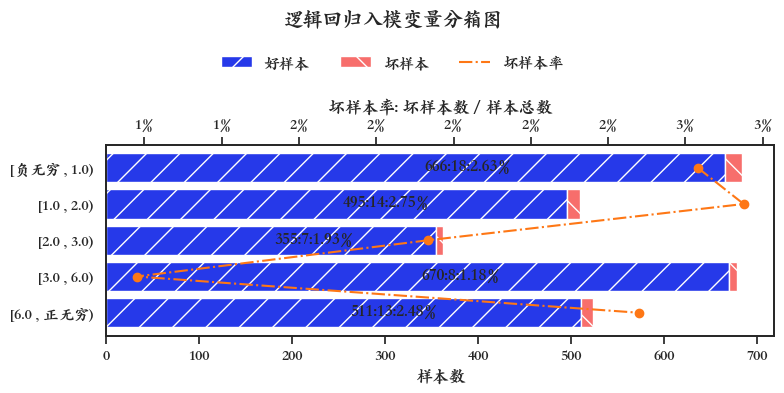

山河灵狐分V3


指标名称      指标含义             分箱  样本总数   样本占比  好样本数  好样本占比  坏样本数  坏样本占比  \
0  山河灵狐分V3  逻辑回归入模变量  [负无穷 , 547.0)   463 0.1679   454 0.1683     9 0.1500   
1  山河灵狐分V3  逻辑回归入模变量  [547.0 , 正无穷)  2294 0.8321  2243 0.8317    51 0.8500   

    坏样本率  分档WOE值  分档IV值  指标IV值  LIFT值  累积LIFT值  累积好样本数  累积坏样本数   分档KS值  
0 0.0194  0.1153 0.0021 0.0025 0.8932   0.8932     454       9 -0.0183  
1 0.0222 -0.0218 0.0004 0.0025 1.0216   1.0000    2697      60  0.0000

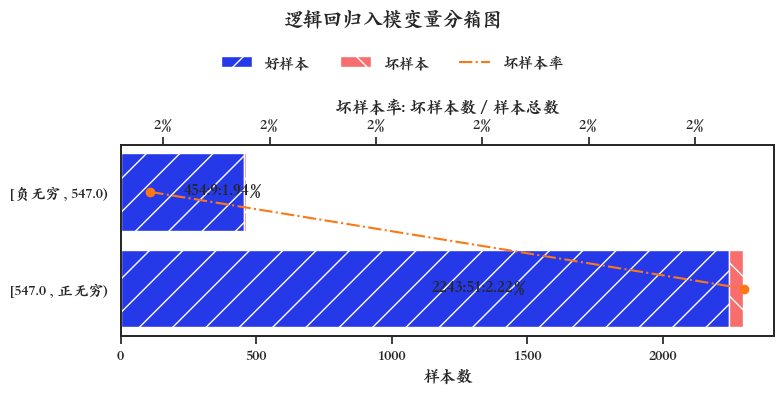

1周内手机号码申请次数


指标名称      指标含义           分箱  样本总数   样本占比  好样本数  好样本占比  坏样本数  坏样本占比  \
0  1周内手机号码申请次数  逻辑回归入模变量  [负无穷 , 1.0)  1824 0.6616  1780 0.6600    44 0.7333   
1  1周内手机号码申请次数  逻辑回归入模变量  [1.0 , 2.0)   460 0.1668   454 0.1683     6 0.1000   
2  1周内手机号码申请次数  逻辑回归入模变量  [2.0 , 正无穷)   473 0.1716   463 0.1717    10 0.1667   

    坏样本率  分档WOE值  分档IV值  指标IV值  LIFT值  累积LIFT值  累积好样本数  累积坏样本数  分档KS值  
0 0.0241 -0.1054 0.0077 0.0435 1.1084   1.1084    1780      44 0.0733  
1 0.0130  0.5208 0.0356 0.0435 0.5993   1.0059    2234      50 0.0050  
2 0.0211  0.0296 0.0001 0.0435 0.9715   1.0000    2697      60 0.0000

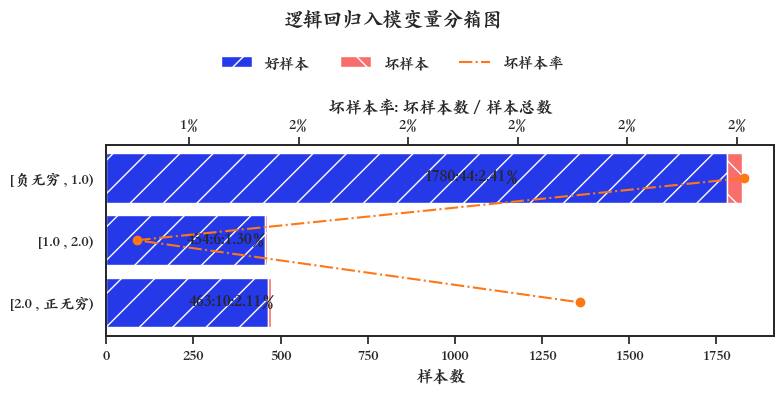

1月内手机号码申请命中互联网金融平台数


指标名称      指标含义           分箱  样本总数   样本占比  好样本数  好样本占比  坏样本数  \
0  1月内手机号码申请命中互联网金融平台数  逻辑回归入模变量  [负无穷 , 1.0)  1400 0.5078  1365 0.5061    35   
1  1月内手机号码申请命中互联网金融平台数  逻辑回归入模变量  [1.0 , 2.0)   850 0.3083   842 0.3122     8   
2  1月内手机号码申请命中互联网金融平台数  逻辑回归入模变量  [2.0 , 正无穷)   507 0.1839   490 0.1817    17   

   坏样本占比   坏样本率  分档WOE值  分档IV值  指标IV值  LIFT值  累积LIFT值  累积好样本数  累积坏样本数   分档KS值  
0 0.5833 0.0250 -0.1420 0.0110 0.2083 1.1487   1.1487    1365      35  0.0772  
1 0.1333 0.0094  0.8508 0.1522 0.2083 0.4325   0.8782    2207      43 -0.1016  
2 0.2833 0.0335 -0.4444 0.0452 0.2083 1.5407   1.0000    2697      60  0.0000

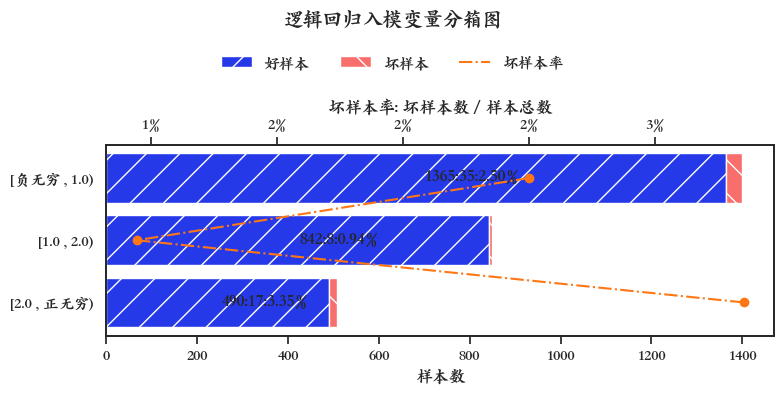

12个月内手机号码申请平台数


指标名称      指标含义             分箱  样本总数   样本占比  好样本数  好样本占比  坏样本数  \
0  12个月内手机号码申请平台数  逻辑回归入模变量    [负无穷 , 6.0)   340 0.1233   337 0.1250     3   
1  12个月内手机号码申请平台数  逻辑回归入模变量   [6.0 , 18.0)  1102 0.3997  1074 0.3982    28   
2  12个月内手机号码申请平台数  逻辑回归入模变量  [18.0 , 23.0)   338 0.1226   337 0.1250     1   
3  12个月内手机号码申请平台数  逻辑回归入模变量   [23.0 , 正无穷)   977 0.3544   949 0.3519    28   

   坏样本占比   坏样本率  分档WOE值  分档IV值  指标IV值  LIFT值  累积LIFT值  累积好样本数  累积坏样本数   分档KS值  
0 0.0500 0.0088  0.9159 0.0687 0.3301 0.4054   0.4054     337       3 -0.0750  
1 0.4667 0.0254 -0.1586 0.0109 0.3301 1.1675   0.9878    1411      31 -0.0065  
2 0.0167 0.0030  2.0145 0.2181 0.3301 0.1359   0.8261    1748      32 -0.1148  
3 0.4667 0.0287 -0.2823 0.0324 0.3301 1.3169   1.0000    2697      60  0.0000

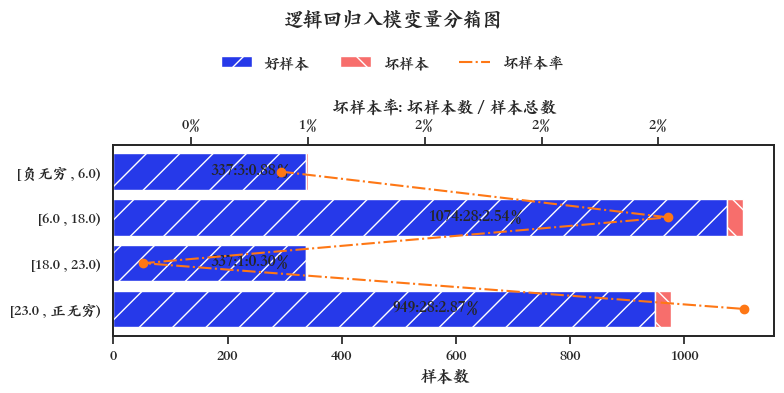

墨竹还款能力评估


指标名称      指标含义             分箱  样本总数   样本占比  好样本数  好样本占比  坏样本数  坏样本占比  \
0  墨竹还款能力评估  逻辑回归入模变量   [负无穷 , 43.0)   626 0.2271   610 0.2262    16 0.2667   
1  墨竹还款能力评估  逻辑回归入模变量  [43.0 , 50.0)   593 0.2151   574 0.2128    19 0.3167   
2  墨竹还款能力评估  逻辑回归入模变量   [50.0 , 正无穷)  1538 0.5579  1513 0.5610    25 0.4167   

    坏样本率  分档WOE值  分档IV值  指标IV值  LIFT值  累积LIFT值  累积好样本数  累积坏样本数  分档KS值  
0 0.0256 -0.1647 0.0067 0.0909 1.1744   1.1744     610      16 0.0405  
1 0.0320 -0.3974 0.0413 0.0909 1.4723   1.3193    1184      35 0.1443  
2 0.0163  0.2974 0.0429 0.0909 0.7469   1.0000    2697      60 0.0000

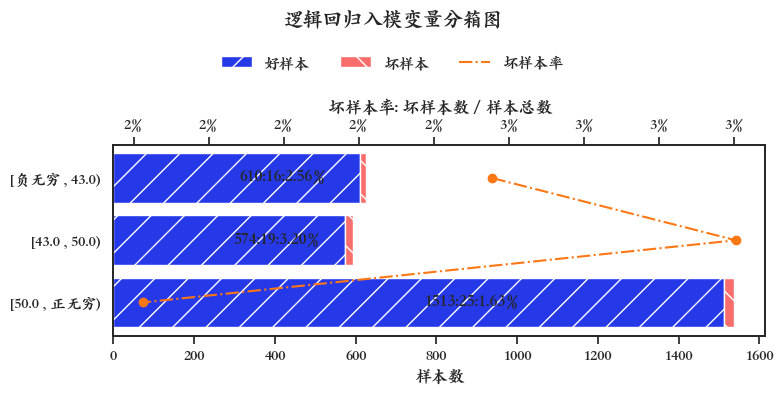

1月内手机号码申请平台数


指标名称      指标含义           分箱  样本总数   样本占比  好样本数  好样本占比  坏样本数  坏样本占比  \
0  1月内手机号码申请平台数  逻辑回归入模变量  [负无穷 , 1.0)   620 0.2249   604 0.2240    16 0.2667   
1  1月内手机号码申请平台数  逻辑回归入模变量  [1.0 , 5.0)  1308 0.4744  1289 0.4779    19 0.3167   
2  1月内手机号码申请平台数  逻辑回归入模变量  [5.0 , 9.0)   501 0.1817   483 0.1791    18 0.3000   
3  1月内手机号码申请平台数  逻辑回归入模变量  [9.0 , 正无穷)   328 0.1190   321 0.1190     7 0.1167   

    坏样本率  分档WOE值  分档IV值  指标IV值  LIFT值  累积LIFT值  累积好样本数  累积坏样本数   分档KS值  
0 0.0258 -0.1746 0.0075 0.1363 1.1858   1.1858     604      16  0.0427  
1 0.0145  0.4116 0.0664 0.1363 0.6675   0.8342    1893      35 -0.1186  
2 0.0359 -0.5159 0.0624 0.1363 1.6509   1.0026    2376      53  0.0024  
3 0.0213  0.0200 0.0000 0.1363 0.9806   1.0000    2697      60  0.0000

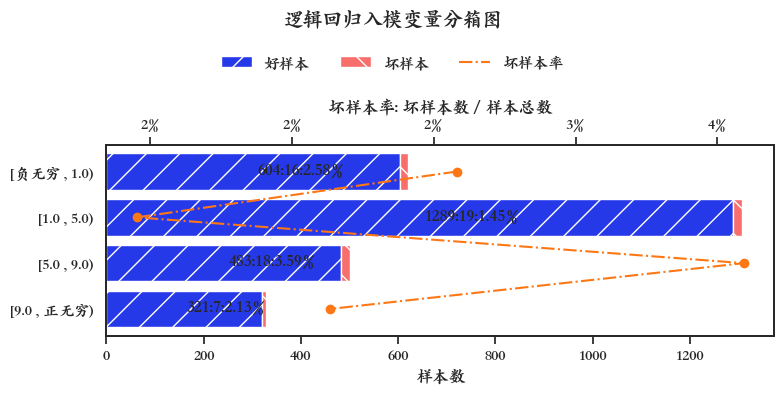

山河麒麟分V3


指标名称      指标含义             分箱  样本总数   样本占比  好样本数  好样本占比  坏样本数  坏样本占比  \
0  山河麒麟分V3  逻辑回归入模变量  [负无穷 , 557.0)   778 0.2822   752 0.2788    26 0.4333   
1  山河麒麟分V3  逻辑回归入模变量  [557.0 , 正无穷)  1979 0.7178  1945 0.7212    34 0.5667   

    坏样本率  分档WOE值  分档IV值  指标IV值  LIFT值  累积LIFT值  累积好样本数  累积坏样本数  分档KS值  
0 0.0334 -0.4409 0.0681 0.1054 1.5356   1.5356     752      26 0.1545  
1 0.0172  0.2411 0.0373 0.1054 0.7894   1.0000    2697      60 0.0000

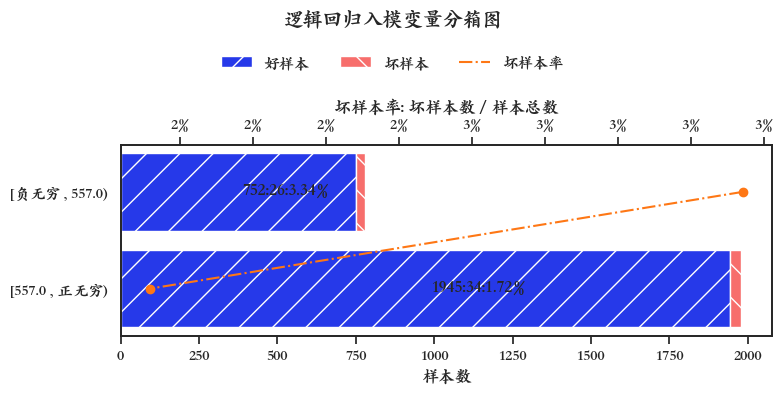

6月内手机号码申请命中金融科技平台数


指标名称      指标含义            分箱  样本总数   样本占比  好样本数  好样本占比  坏样本数  \
0  6月内手机号码申请命中金融科技平台数  逻辑回归入模变量   [负无穷 , 3.0)   804 0.2916   793 0.2940    11   
1  6月内手机号码申请命中金融科技平台数  逻辑回归入模变量   [3.0 , 6.0)   605 0.2194   588 0.2180    17   
2  6月内手机号码申请命中金融科技平台数  逻辑回归入模变量  [6.0 , 11.0)   612 0.2220   604 0.2240     8   
3  6月内手机号码申请命中金融科技平台数  逻辑回归入模变量  [11.0 , 正无穷)   736 0.2670   712 0.2640    24   

   坏样本占比   坏样本率  分档WOE值  分档IV值  指标IV值  LIFT值  累积LIFT值  累积好样本数  累积坏样本数   分档KS值  
0 0.1833 0.0137  0.4724 0.0523 0.1729 0.6287   0.6287     793      11 -0.1107  
1 0.2833 0.0281 -0.2620 0.0171 0.1729 1.2912   0.9131    1381      28 -0.0454  
2 0.1333 0.0131  0.5186 0.0470 0.1729 0.6007   0.8185    1985      36 -0.1360  
3 0.4000 0.0326 -0.4155 0.0565 0.1729 1.4984   1.0000    2697      60  0.0000

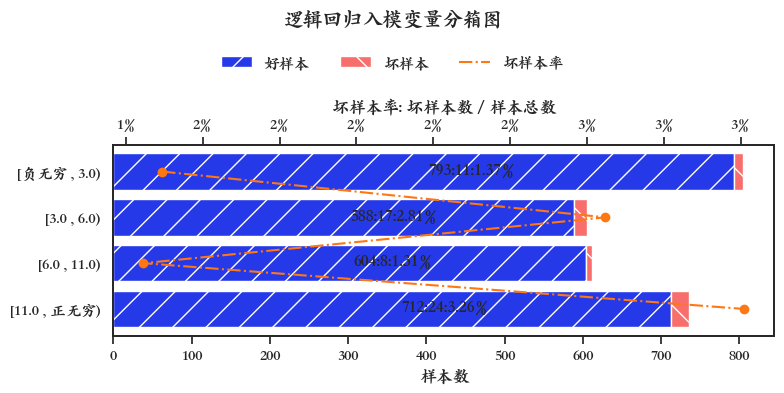

6月内手机号码申请命中互联网金融次数


指标名称      指标含义           分箱  样本总数   样本占比  好样本数  好样本占比  坏样本数  \
0  6月内手机号码申请命中互联网金融次数  逻辑回归入模变量  [负无穷 , 6.0)  1696 0.6152  1661 0.6159    35   
1  6月内手机号码申请命中互联网金融次数  逻辑回归入模变量  [6.0 , 8.0)   285 0.1034   284 0.1053     1   
2  6月内手机号码申请命中互联网金融次数  逻辑回归入模变量  [8.0 , 正无穷)   776 0.2815   752 0.2788    24   

   坏样本占比   坏样本率  分档WOE值  分档IV值  指标IV值  LIFT值  累积LIFT值  累积好样本数  累积坏样本数   分档KS值  
0 0.5833 0.0206  0.0543 0.0018 0.2089 0.9483   0.9483    1661      35 -0.0325  
1 0.0167 0.0035  1.8434 0.1634 0.2089 0.1612   0.8350    1945      36 -0.1212  
2 0.4000 0.0309 -0.3609 0.0437 0.2089 1.4211   1.0000    2697      60  0.0000

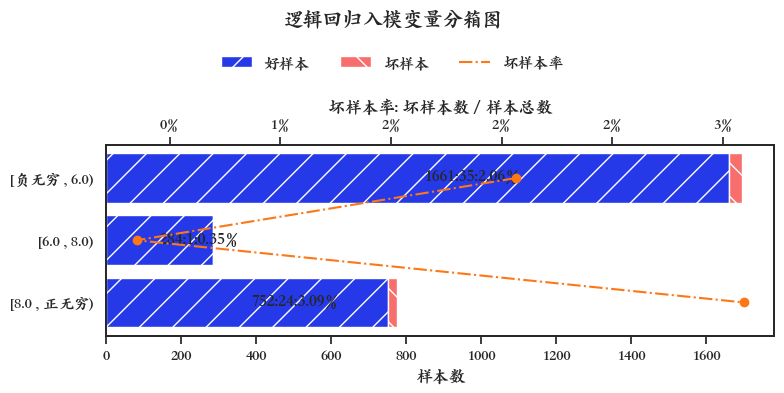

6月内手机号码申请命中银行平台数


指标名称      指标含义           分箱  样本总数   样本占比  好样本数  好样本占比  坏样本数  \
0  6月内手机号码申请命中银行平台数  逻辑回归入模变量  [负无穷 , 3.0)  1736 0.6297  1692 0.6274    44   
1  6月内手机号码申请命中银行平台数  逻辑回归入模变量  [3.0 , 4.0)   378 0.1371   375 0.1390     3   
2  6月内手机号码申请命中银行平台数  逻辑回归入模变量  [4.0 , 正无穷)   643 0.2332   630 0.2336    13   

   坏样本占比   坏样本率  分档WOE值  分档IV值  指标IV值  LIFT值  累积LIFT值  累积好样本数  累积坏样本数  分档KS值  
0 0.7333 0.0253 -0.1561 0.0165 0.1089 1.1646   1.1646    1692      44 0.1060  
1 0.0500 0.0079  1.0227 0.0911 0.1089 0.3647   1.0216    2067      47 0.0169  
2 0.2167 0.0202  0.0752 0.0013 0.1089 0.9290   1.0000    2697      60 0.0000

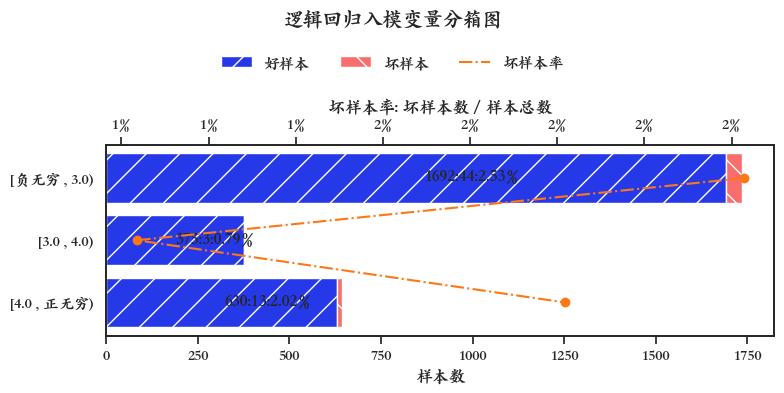

放款期数


指标名称      指标含义          分箱  样本总数   样本占比  好样本数  好样本占比  坏样本数  坏样本占比   坏样本率  \
0  放款期数  逻辑回归入模变量   [负无穷 , 6)   544 0.1973   528 0.1958    16 0.2667 0.0294   
1  放款期数  逻辑回归入模变量    [6 , 12)   411 0.1491   407 0.1509     4 0.0667 0.0097   
2  放款期数  逻辑回归入模变量  [12 , 正无穷)  1802 0.6536  1762 0.6533    40 0.6667 0.0222   

   分档WOE值  分档IV值  指标IV值  LIFT值  累积LIFT值  累积好样本数  累积坏样本数   分档KS值  
0 -0.3090 0.0219 0.0910 1.3515   1.3515     528      16  0.0709  
1  0.8170 0.0688 0.0910 0.4472   0.9623     935      20 -0.0133  
2 -0.0202 0.0003 0.0910 1.0200   1.0000    2697      60  0.0000

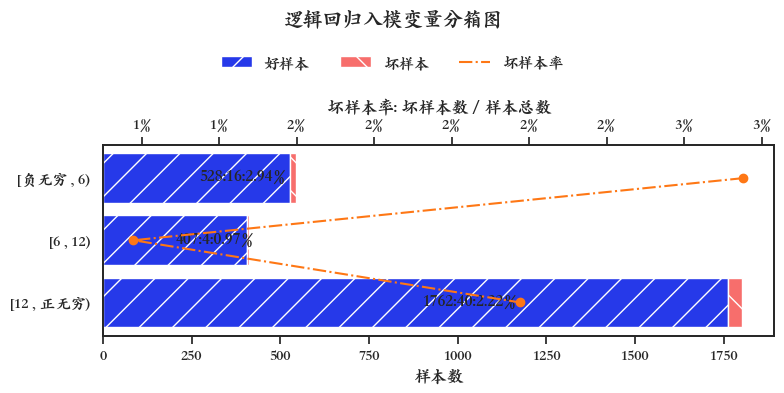

3月内手机号码申请命中互联网金融平台数


指标名称      指标含义           分箱  样本总数   样本占比  好样本数  好样本占比  坏样本数  \
0  3月内手机号码申请命中互联网金融平台数  逻辑回归入模变量  [负无穷 , 1.0)   571 0.2071   560 0.2076    11   
1  3月内手机号码申请命中互联网金融平台数  逻辑回归入模变量  [1.0 , 3.0)  1394 0.5056  1367 0.5069    27   
2  3月内手机号码申请命中互联网金融平台数  逻辑回归入模变量  [3.0 , 4.0)   325 0.1179   313 0.1161    12   
3  3月内手机号码申请命中互联网金融平台数  逻辑回归入模变量  [4.0 , 正无穷)   467 0.1694   457 0.1694    10   

   坏样本占比   坏样本率  分档WOE值  分档IV值  指标IV值  LIFT值  累积LIFT值  累积好样本数  累积坏样本数   分档KS值  
0 0.1833 0.0193  0.1245 0.0030 0.0555 0.8852   0.8852     560      11 -0.0243  
1 0.4500 0.0194  0.1190 0.0068 0.0555 0.8900   0.8886    1927      38 -0.0812  
2 0.2000 0.0369 -0.5443 0.0457 0.0555 1.6966   1.0033    2240      50  0.0028  
3 0.1667 0.0214  0.0165 0.0000 0.0555 0.9839   1.0000    2697      60  0.0000

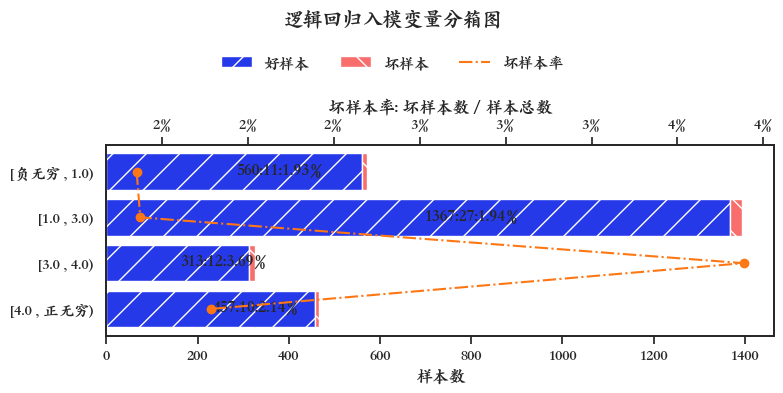

1周内手机号码申请命中互联网金融平台数


指标名称      指标含义           分箱  样本总数   样本占比  好样本数  好样本占比  坏样本数  \
0  1周内手机号码申请命中互联网金融平台数  逻辑回归入模变量  [负无穷 , 1.0)  2335 0.8469  2281 0.8458    54   
1  1周内手机号码申请命中互联网金融平台数  逻辑回归入模变量  [1.0 , 正无穷)   422 0.1531   416 0.1542     6   

   坏样本占比   坏样本率  分档WOE值  分档IV值  指标IV值  LIFT值  累积LIFT值  累积好样本数  累积坏样本数  分档KS值  
0 0.9000 0.0231 -0.0622 0.0034 0.0269 1.0627   1.0627    2281      54 0.0542  
1 0.1000 0.0142  0.4334 0.0235 0.0269 0.6533   1.0000    2697      60 0.0000

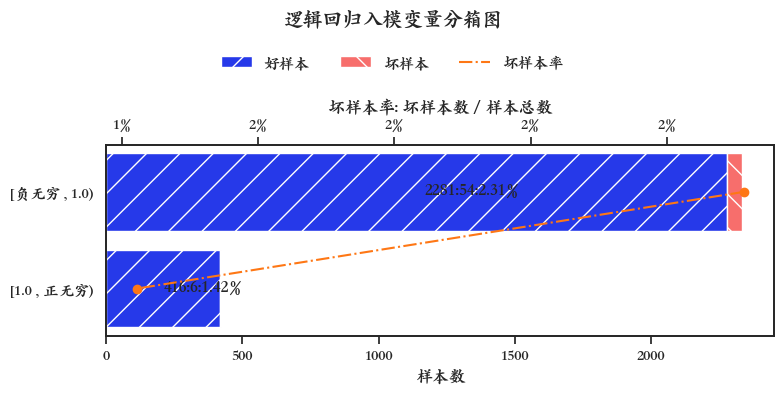

6月内手机号码申请命中金融科技次数


指标名称      指标含义            分箱  样本总数   样本占比  好样本数  好样本占比  坏样本数  \
0  6月内手机号码申请命中金融科技次数  逻辑回归入模变量   [负无穷 , 1.0)   305 0.1106   297 0.1101     8   
1  6月内手机号码申请命中金融科技次数  逻辑回归入模变量   [1.0 , 3.0)   447 0.1621   442 0.1639     5   
2  6月内手机号码申请命中金融科技次数  逻辑回归入模变量  [3.0 , 11.0)   849 0.3079   831 0.3081    18   
3  6月内手机号码申请命中金融科技次数  逻辑回归入模变量  [11.0 , 正无穷)  1156 0.4193  1127 0.4179    29   

   坏样本占比   坏样本率  分档WOE值  分档IV值  指标IV值  LIFT值  累积LIFT值  累积好样本数  累积坏样本数   分档KS值  
0 0.1333 0.0262 -0.1913 0.0044 0.0687 1.2052   1.2052     297       8  0.0232  
1 0.0833 0.0112  0.6763 0.0545 0.0687 0.5140   0.7943     739      13 -0.0573  
2 0.3000 0.0212  0.0267 0.0002 0.0687 0.9742   0.8897    1570      31 -0.0655  
3 0.4833 0.0251 -0.1455 0.0095 0.0687 1.1527   1.0000    2697      60  0.0000

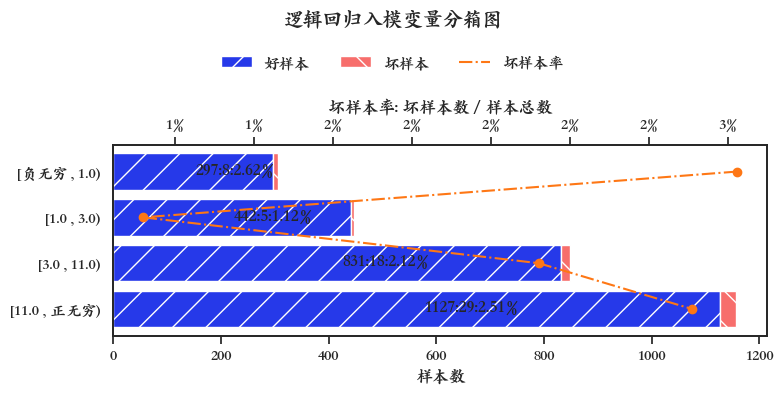

12月内手机号码申请命中互联网金融平台数


指标名称      指标含义           分箱  样本总数   样本占比  好样本数  好样本占比  \
0  12月内手机号码申请命中互联网金融平台数  逻辑回归入模变量  [负无穷 , 2.0)   688 0.2495   676 0.2506   
1  12月内手机号码申请命中互联网金融平台数  逻辑回归入模变量  [2.0 , 4.0)   889 0.3225   864 0.3204   
2  12月内手机号码申请命中互联网金融平台数  逻辑回归入模变量  [4.0 , 5.0)   333 0.1208   332 0.1231   
3  12月内手机号码申请命中互联网金融平台数  逻辑回归入模变量  [5.0 , 7.0)   428 0.1552   421 0.1561   
4  12月内手机号码申请命中互联网金融平台数  逻辑回归入模变量  [7.0 , 正无穷)   419 0.1520   404 0.1498   

   坏样本数  坏样本占比   坏样本率  分档WOE值  分档IV值  指标IV值  LIFT值  累积LIFT值  累积好样本数  累积坏样本数  \
0    12 0.2000 0.0174  0.2257 0.0114 0.3124 0.8015   0.8015     676      12   
1    25 0.4167 0.0281 -0.2629 0.0253 0.3124 1.2922   1.0781    1540      37   
2     1 0.0167 0.0030  1.9995 0.2128 0.3124 0.1380   0.9142    1872      38   
3     7 0.1167 0.0164  0.2912 0.0115 0.3124 0.7515   0.8844    2293      45   
4    15 0.2500 0.0358 -0.5122 0.0513 0.3124 1.6450   1.0000    2697      60   

    分档KS值  
0 -0.0506  
1  0.0457  
2 -0.0608  
3 -0.1002  
4  0.0000

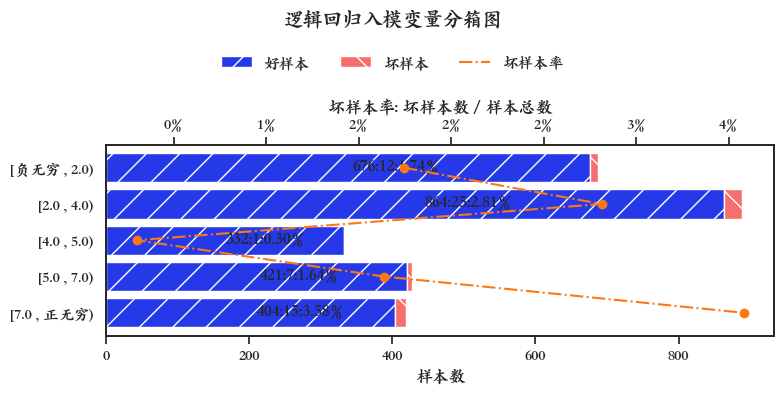

12个月内手机号码申请次数


指标名称      指标含义             分箱  样本总数   样本占比  好样本数  好样本占比  坏样本数  \
0  12个月内手机号码申请次数  逻辑回归入模变量   [负无穷 , 20.0)   974 0.3533   949 0.3519    25   
1  12个月内手机号码申请次数  逻辑回归入模变量  [20.0 , 61.0)  1108 0.4019  1097 0.4067    11   
2  12个月内手机号码申请次数  逻辑回归入模变量   [61.0 , 正无穷)   675 0.2448   651 0.2414    24   

   坏样本占比   坏样本率  分档WOE值  分档IV值  指标IV值  LIFT值  累积LIFT值  累积好样本数  累积坏样本数   分档KS值  
0 0.4167 0.0257 -0.1690 0.0110 0.2691 1.1794   1.1794     949      25  0.0648  
1 0.1833 0.0099  0.7969 0.1780 0.2691 0.4562   0.7945    2046      36 -0.1586  
2 0.4000 0.0356 -0.5051 0.0801 0.2691 1.6338   1.0000    2697      60  0.0000

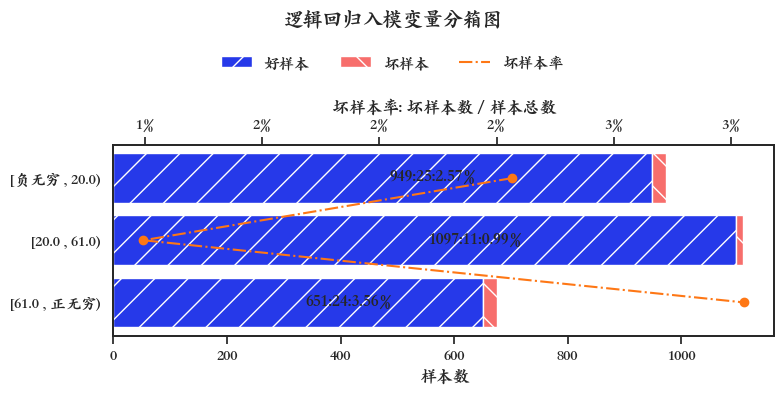

6月内手机号码申请命中互联网金融平台数


指标名称      指标含义           分箱  样本总数   样本占比  好样本数  好样本占比  坏样本数  \
0  6月内手机号码申请命中互联网金融平台数  逻辑回归入模变量  [负无穷 , 1.0)   289 0.1048   284 0.1053     5   
1  6月内手机号码申请命中互联网金融平台数  逻辑回归入模变量  [1.0 , 3.0)  1263 0.4581  1233 0.4572    30   
2  6月内手机号码申请命中互联网金融平台数  逻辑回归入模变量  [3.0 , 4.0)   421 0.1527   419 0.1554     2   
3  6月内手机号码申请命中互联网金融平台数  逻辑回归入模变量  [4.0 , 正无穷)   784 0.2844   761 0.2822    23   

   坏样本占比   坏样本率  分档WOE值  分档IV值  指标IV值  LIFT值  累积LIFT值  累积好样本数  累积坏样本数   分档KS值  
0 0.0833 0.0173  0.2340 0.0051 0.2278 0.7950   0.7950     284       5 -0.0220  
1 0.5000 0.0238 -0.0895 0.0038 0.2278 1.0914   1.0362    1517      35  0.0209  
2 0.0333 0.0048  1.5391 0.1878 0.2278 0.2183   0.8617    1936      37 -0.1012  
3 0.3833 0.0293 -0.3064 0.0310 0.2278 1.3480   1.0000    2697      60  0.0000

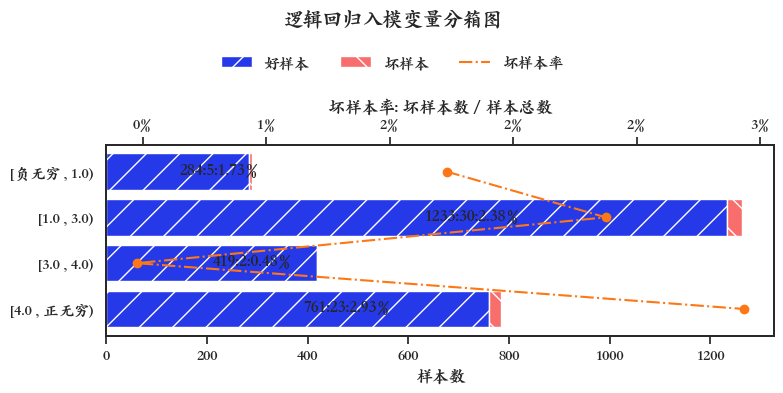

3月内手机号码申请命中信托平台数


指标名称      指标含义           分箱  样本总数   样本占比  好样本数  好样本占比  坏样本数  \
0  3月内手机号码申请命中信托平台数  逻辑回归入模变量  [负无穷 , 1.0)  2204 0.7994  2155 0.7990    49   
1  3月内手机号码申请命中信托平台数  逻辑回归入模变量  [1.0 , 正无穷)   553 0.2006   542 0.2010    11   

   坏样本占比   坏样本率  分档WOE值  分档IV值  指标IV值  LIFT值  累积LIFT值  累积好样本数  累积坏样本数  分档KS值  
0 0.8167 0.0222 -0.0218 0.0004 0.0020 1.0216   1.0216    2155      49 0.0176  
1 0.1833 0.0199  0.0918 0.0016 0.0020 0.9140   1.0000    2697      60 0.0000

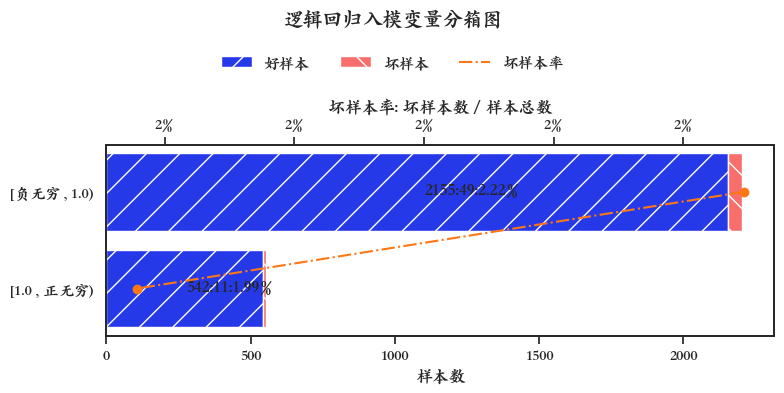

In [37]:
for col in logistic.feature_names_in_:
    print(col)
    feature_table = sp.feature_bin_stats(data, col, target=target, desc=feature_map.get(col, "") or "逻辑回归入模变量", combiner=feature_pipeline.named_steps["combiner"])
    _ = sp.bin_plot(feature_table, desc=feature_map.get(col, "") or "逻辑回归入模变量", figsize=(8, 4), anchor=0.9)
    
    display(feature_table)
    plt.show()

7 评分卡模型转换

In [38]:
sp.ScoreCard?

Init signature:
sp.ScoreCard(
    target='target',
    pdo=60,
    rate=2,
    base_odds=35,
    base_score=750,
    combiner={},
    transer=None,
    pretrain_lr=None,
    pipeline=None,
    **kwargs,
)
Docstring:     
Base class for all estimators in scikit-learn.

Notes
-----
All estimators should specify all the parameters that can be set
at the class level in their ``__init__`` as explicit keyword
arguments (no ``*args`` or ``**kwargs``).
Init docstring:
评分卡模型转换

Args:
    target: 数据集中标签名称，默认 target
    pdo: odds 每增加 rate 倍时减少 pdo 分，默认 60
    rate: 倍率
    base_odds: 基础 odds，通常根据业务经验设置的基础比率（违约概率/正常概率），估算方法：（1-样本坏客户占比）/坏客户占比，默认 35，即 35:1 => 0.972 => 坏样本率 2.8%
    base_score: 基础 odds 对应的分数，默认 750
    combiner: 分箱转换器，传入 pipeline 时可以为None
    transer: woe转换器，传入 pipeline 时可以为None
    pretrain_lr: 预训练好的逻辑回归模型，可以不传
    pipeline: 训练好的 pipeline，必须包含 Combiner 和 WOETransformer
    **kwargs: 其他相关参数，具体参考 toad.ScoreCard
File:           ~/Desktop/workspace/scorecardpipeline/scorecardpipeline/mod

7.1 评分卡转换

In [39]:
# 逻辑回归模型转评分卡
card = sp.ScoreCard(target=target, pipeline=feature_pipeline, pretrain_lr=logistic)
card

ScoreCard(combiner=<toad.transform.Combiner object at 0x7f7801366400>,
          pipeline=Pipeline(steps=[('preprocessing_select', FeatureSelection()),
                                   ('combiner', Combiner(min_bin_size=0.1)),
                                   ('transform', WOETransformer(exclude=[])),
                                   ('processing_select',
                                    FeatureSelection(engine='toad')),
                                   ('stepwise', StepwiseSelection())]),
          pretrain_lr=ITLubberLogisticRegression(),
          transer=<toad.transform.WOETransformer object at 0x7f7801366d60>)

In [40]:
# 训练
card.fit(woe_train)

# 预测
train["score"] = card.predict(train)
test["score"] = card.predict(test)

7.2 评分卡信息

In [41]:
# 获取评分卡刻度信息
card.scorecard_scale()

刻度项      刻度值                                               备注
0   base_odds  35.0000  根据业务经验设置的基础比率（违约概率/正常概率），估算方法：（1-样本坏客户占比）/坏客户占比
1  base_score 750.0000                                      基础ODDS对应的分数
2        rate   2.0000                                          设置分数的倍率
3         pdo  60.0000                         表示分数增长PDO时，ODDS值增长到RATE倍
4           B  86.5617                          补偿值，计算方式：pdo / ln(rate)
5           A 442.2430           刻度，计算方式：base_score - B * ln(base_odds)

In [42]:
# 获取评分卡明细
card.scorecard_points(feature_map=feature_map)

变量名称 变量含义           变量分箱     对应分数
0              圈团3浓度分V1       [-inf ~ 20.0)  78.0876
1              圈团3浓度分V1       [20.0 ~ 22.0) -20.4834
2              圈团3浓度分V1       [22.0 ~ 29.0)  66.6004
3              圈团3浓度分V1        [29.0 ~ inf) -12.1527
4       6月内手机号码申请命中银行次数        [-inf ~ 1.0)  22.9374
..                  ...  ...            ...      ...
62  6月内手机号码申请命中互联网金融平台数         [1.0 ~ 3.0)  29.9492
63  6月内手机号码申请命中互联网金融平台数         [3.0 ~ 4.0)  94.0286
64  6月内手机号码申请命中互联网金融平台数         [4.0 ~ inf)  26.6602
65     3月内手机号码申请命中信托平台数        [-inf ~ 1.0)  32.7485
66     3月内手机号码申请命中信托平台数         [1.0 ~ inf)  66.0107

[67 rows x 4 columns]

7.3 评分效果

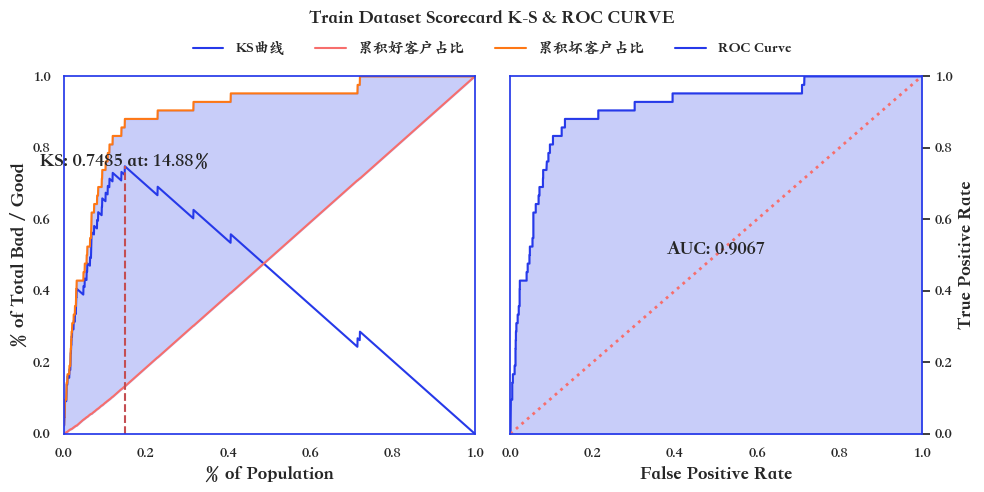

In [43]:
# 评分卡 KS、ROC 曲线
_ = sp.ks_plot(train["score"], train[target], figsize=(10, 5), title="Train Dataset Scorecard")

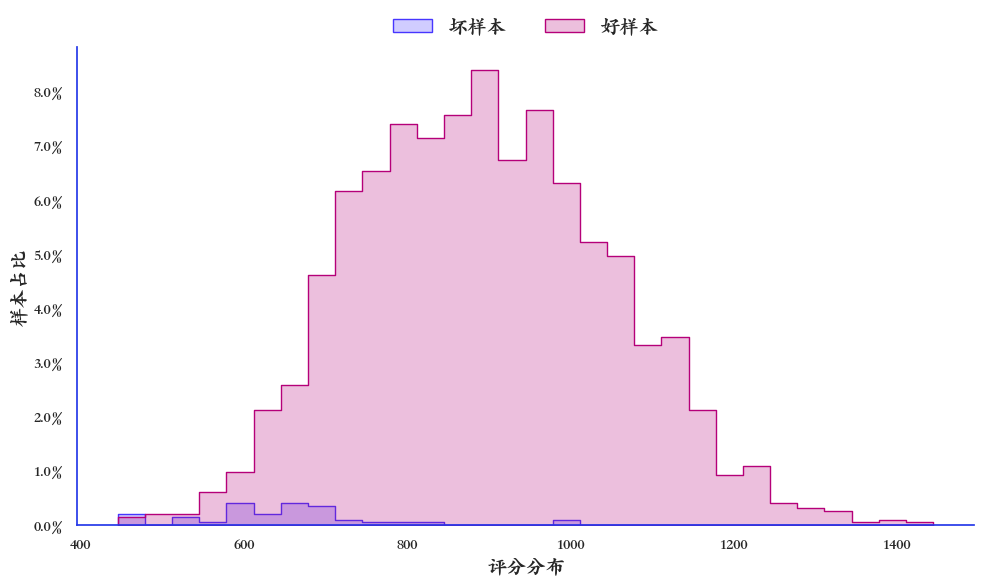

In [44]:
# 评分分布情况
_ = sp.hist_plot(train["score"], train[target], figsize=(10, 6))

指标名称     指标含义             分箱     样本总数   样本占比     好样本数  好样本占比    坏样本数  \
0  score  训练集模型评分    [负无穷 , 600)  46.0000 0.0238  33.0000 0.0175 13.0000   
1  score  训练集模型评分    [600 , 700) 181.0000 0.0938 160.0000 0.0848 21.0000   
2  score  训练集模型评分    [700 , 800) 369.0000 0.1913 365.0000 0.1934  4.0000   
3  score  训练集模型评分    [800 , 900) 442.0000 0.2291 440.0000 0.2332  2.0000   
4  score  训练集模型评分   [900 , 1000) 428.0000 0.2219 426.0000 0.2258  2.0000   
5  score  训练集模型评分  [1000 , 1100) 268.0000 0.1389 268.0000 0.1420  0.0000   
6  score  训练集模型评分  [1100 , 1200) 147.0000 0.0762 147.0000 0.0779  0.0000   
7  score  训练集模型评分   [1200 , 正无穷)  48.0000 0.0249  48.0000 0.0254  0.0000   

   坏样本占比   坏样本率  分档WOE值  分档IV值  指标IV值   LIFT值  累积LIFT值    累积好样本数  累积坏样本数  \
0 0.3095 0.2826 -2.8735 0.8392 5.0379 12.9798  12.9798   33.0000 13.0000   
1 0.5000 0.1160 -1.7744 0.7368 5.0379  5.3287   6.8792  193.0000 34.0000   
2 0.0952 0.0108  0.7085 0.0696 5.0379  0.4979   2.9283  558.0000 38.0000   
3 0.0476 0.0045  1.5885 0.2948 5.0379  0.2078   1.7699  998.0000 40.0000   
4 0.0476 0.0047  1.5562 0.2772 5.0379  0.2146   1.3158 1424.0000 42.0000   
5 0.0000 0.0000 11.8638 1.6849 5.0379  0.0000   1.1125 1692.0000 42.0000   
6 0.0000 0.0000 11.2632 0.8774 5.0379  0.0000   1.0255 1839.0000 42.0000   
7 0.0000 0.0000 10.1440 0.2580 5.0379  0.0000   1.0000 1887.0000 42.0000   

   分档KS值  
0 0.2920  
1 0.7072  
2 0.6091  
3 0.4235  
4 0.2454  
5 0.1033  
6 0.0254  
7 0.0000

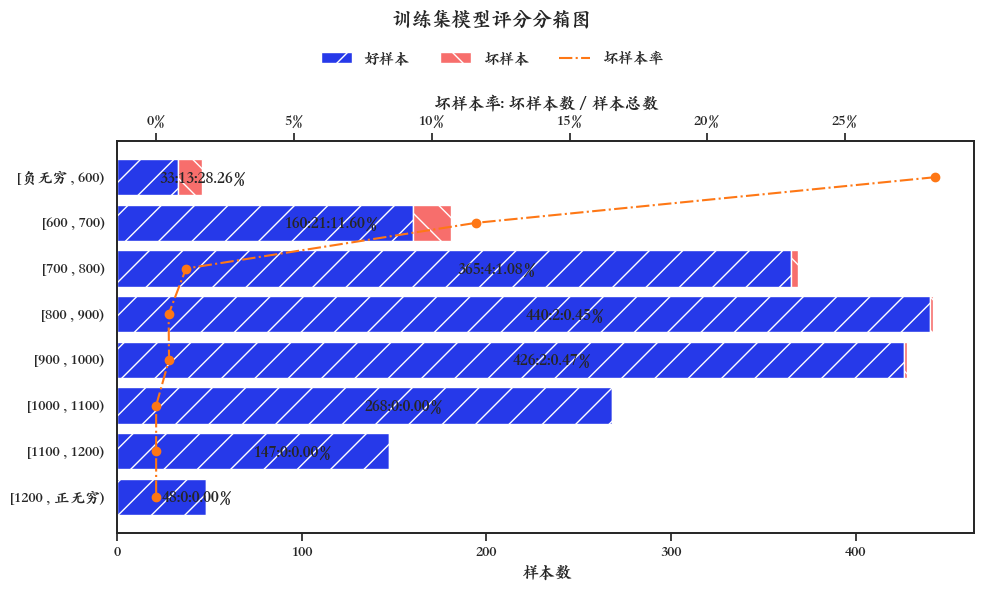

In [45]:
# 训练集评分排序性
score_clip = card.score_clip(train["score"], clip=100)
score_table_train = sp.feature_bin_stats(train, "score", desc="训练集模型评分", target=target, rules=score_clip)
sp.bin_plot(score_table_train, desc="训练集模型评分", figsize=(10, 6), anchor=0.935)

display(score_table_train)

指标名称     指标含义             分箱     样本总数   样本占比     好样本数  好样本占比   坏样本数  \
0  score  测试集模型评分    [负无穷 , 600)  12.0000 0.0145  12.0000 0.0148 0.0000   
1  score  测试集模型评分    [600 , 700)  82.0000 0.0990  77.0000 0.0951 5.0000   
2  score  测试集模型评分    [700 , 800) 158.0000 0.1908 154.0000 0.1901 4.0000   
3  score  测试集模型评分    [800 , 900) 222.0000 0.2681 220.0000 0.2716 2.0000   
4  score  测试集模型评分   [900 , 1000) 176.0000 0.2126 175.0000 0.2160 1.0000   
5  score  测试集模型评分  [1000 , 1100) 105.0000 0.1268 100.0000 0.1235 5.0000   
6  score  测试集模型评分  [1100 , 1200)  52.0000 0.0628  52.0000 0.0642 0.0000   
7  score  测试集模型评分   [1200 , 正无穷)  21.0000 0.0254  20.0000 0.0247 1.0000   

   坏样本占比   坏样本率  分档WOE值  分档IV值  指标IV值  LIFT值  累积LIFT值   累积好样本数  累积坏样本数   分档KS值  
0 0.0000 0.0000  9.6034 0.1423 1.5654 0.0000   0.0000  12.0000  0.0000 -0.0148  
1 0.2778 0.0610 -1.0723 0.1959 1.5654 2.8049   2.4468  89.0000  5.0000  0.1679  
2 0.2222 0.0253 -0.1560 0.0050 1.5654 1.1646   1.6429 243.0000  9.0000  0.2000  
3 0.1111 0.0090  0.8938 0.1435 1.5654 0.4144   1.0675 463.0000 11.0000  0.0395  
4 0.0556 0.0057  1.3581 0.2180 1.5654 0.2614   0.8492 638.0000 12.0000 -0.1210  
5 0.2778 0.0476 -0.8109 0.1251 1.5654 2.1905   1.0358 738.0000 17.0000  0.0333  
6 0.0000 0.0000 11.0697 0.7106 1.5654 0.0000   0.9690 790.0000 17.0000 -0.0309  
7 0.0556 0.0476 -0.8109 0.0250 1.5654 2.1905   1.0000 810.0000 18.0000  0.0000

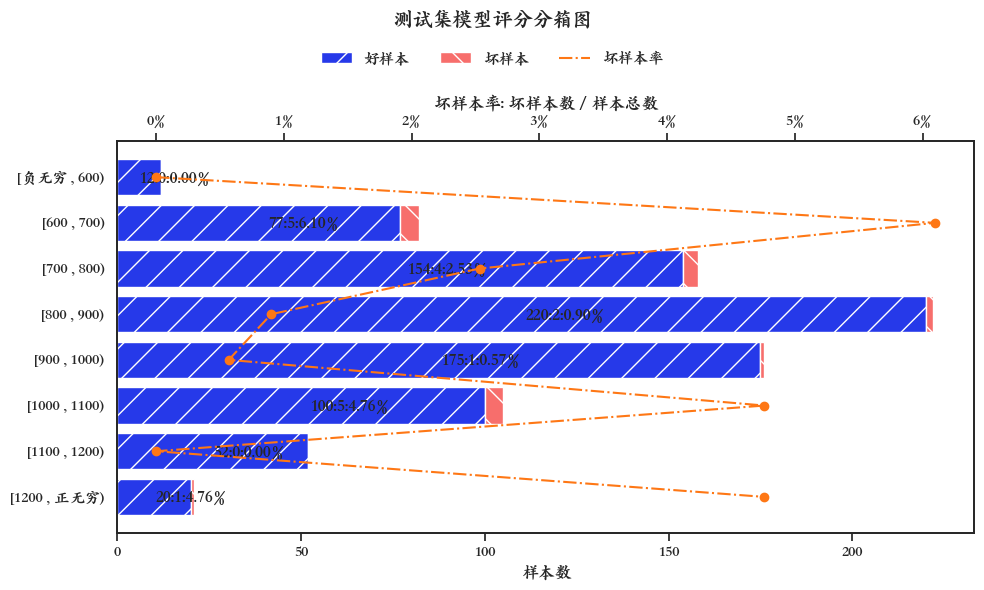

In [46]:
# 测试集评分排序性
score_table_test = sp.feature_bin_stats(test, "score", desc="测试集模型评分", target=target, rules=score_clip)
sp.bin_plot(score_table_test, desc="测试集模型评分", figsize=(10, 6))

display(score_table_test)

7.4 评分卡稳定性

In [47]:
sp.psi_plot?

Signature:
sp.psi_plot(
    expected,
    actual,
    labels=['预期', '实际'],
    desc='',
    save=None,
    colors=['#2639E9', '#F76E6C', '#FE7715'],
    figsize=(15, 8),
    anchor=0.94,
    width=0.35,
    result=False,
    plot=True,
    max_len=None,
    hatch=True,
)
Docstring: <no docstring>
File:      ~/Desktop/workspace/scorecardpipeline/scorecardpipeline/utils.py
Type:      function

In [48]:
sp.csi_plot?

Signature:
sp.csi_plot(
    expected,
    actual,
    score_bins,
    labels=['预期', '实际'],
    desc='',
    save=None,
    colors=['#2639E9', '#F76E6C', '#FE7715'],
    figsize=(15, 8),
    anchor=0.94,
    width=0.35,
    result=False,
    plot=True,
    max_len=None,
    hatch=True,
)
Docstring: <no docstring>
File:      ~/Desktop/workspace/scorecardpipeline/scorecardpipeline/utils.py
Type:      function

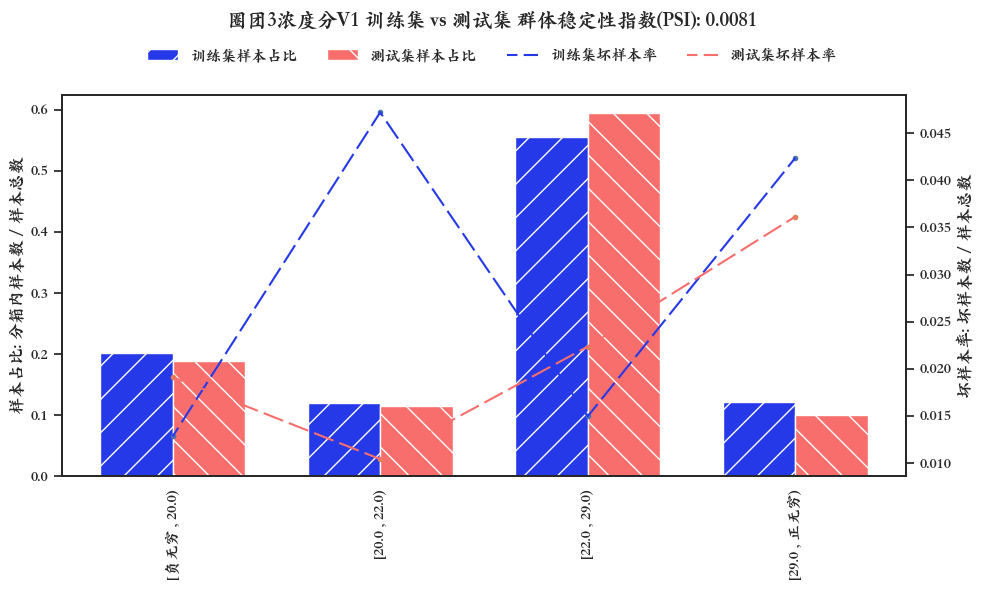

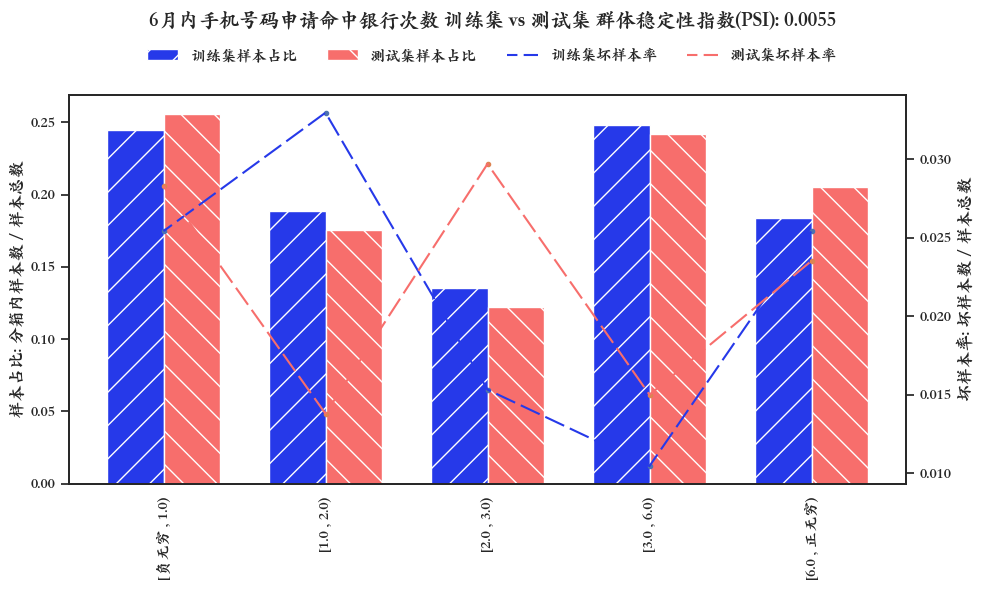

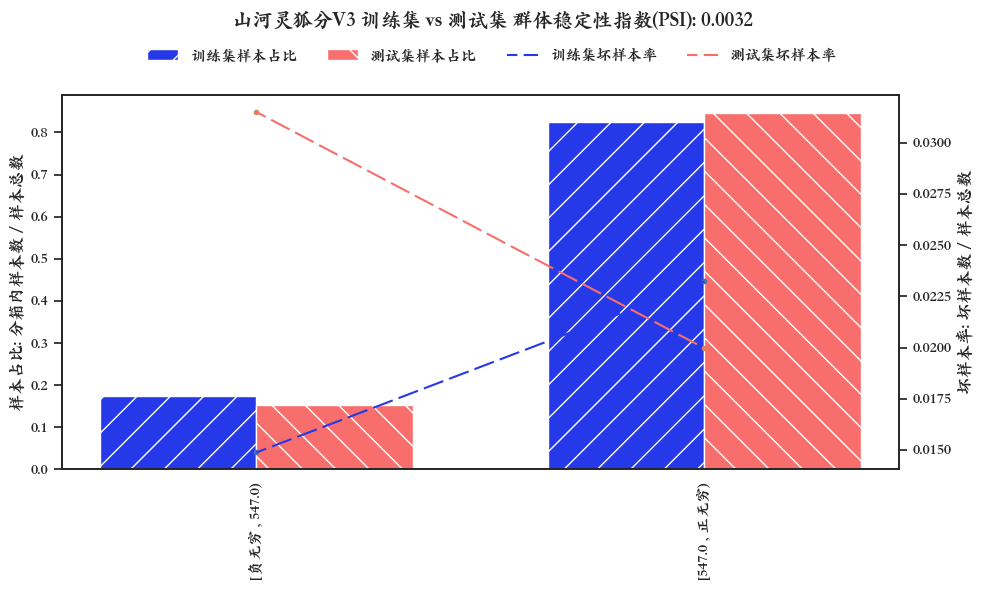

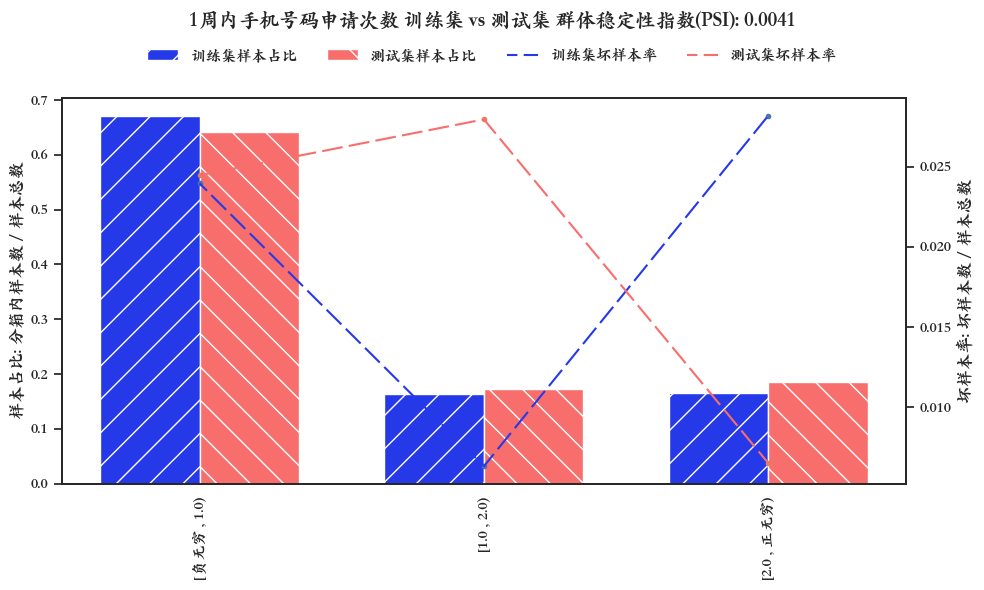

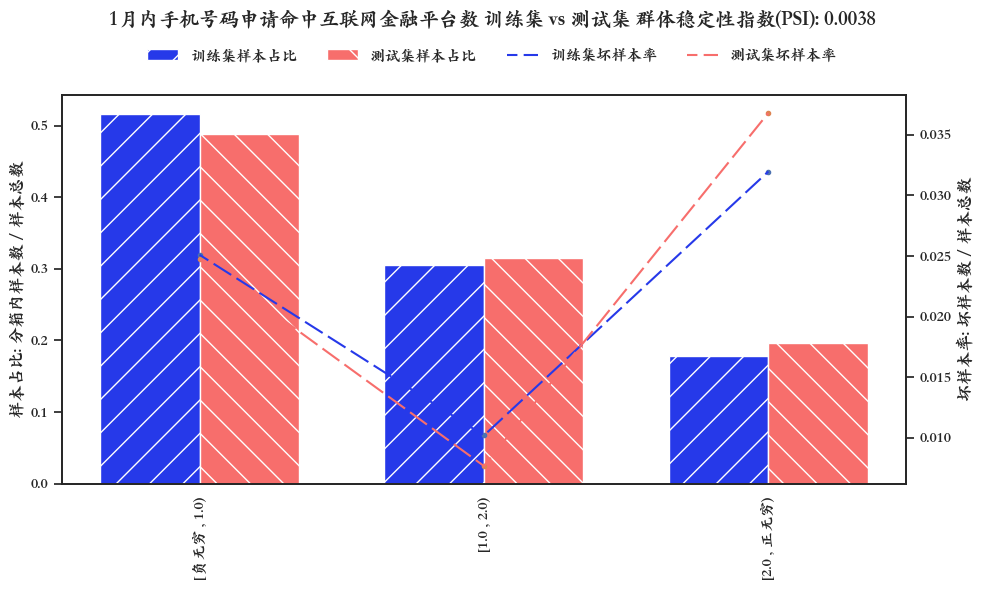

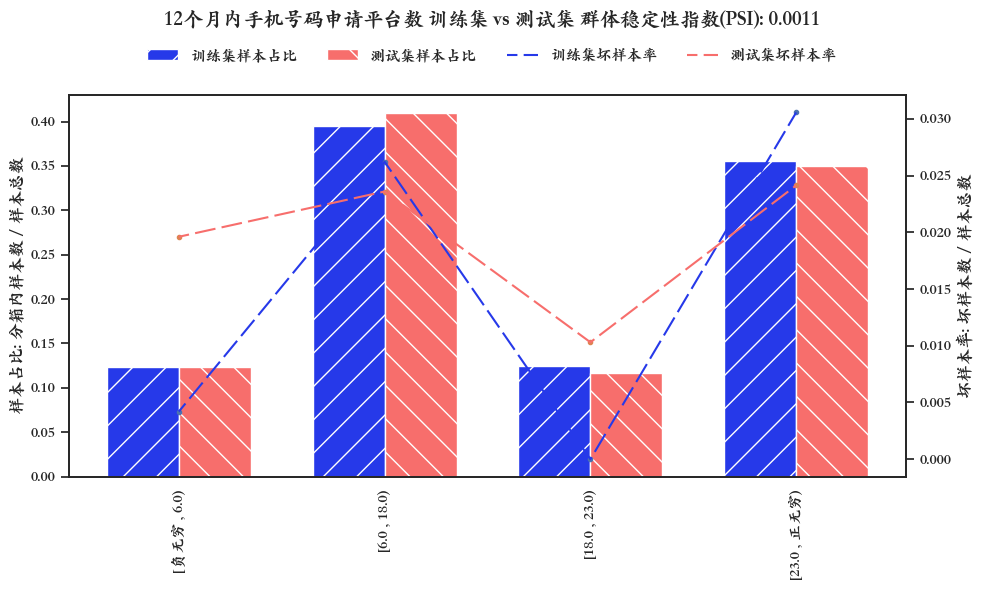

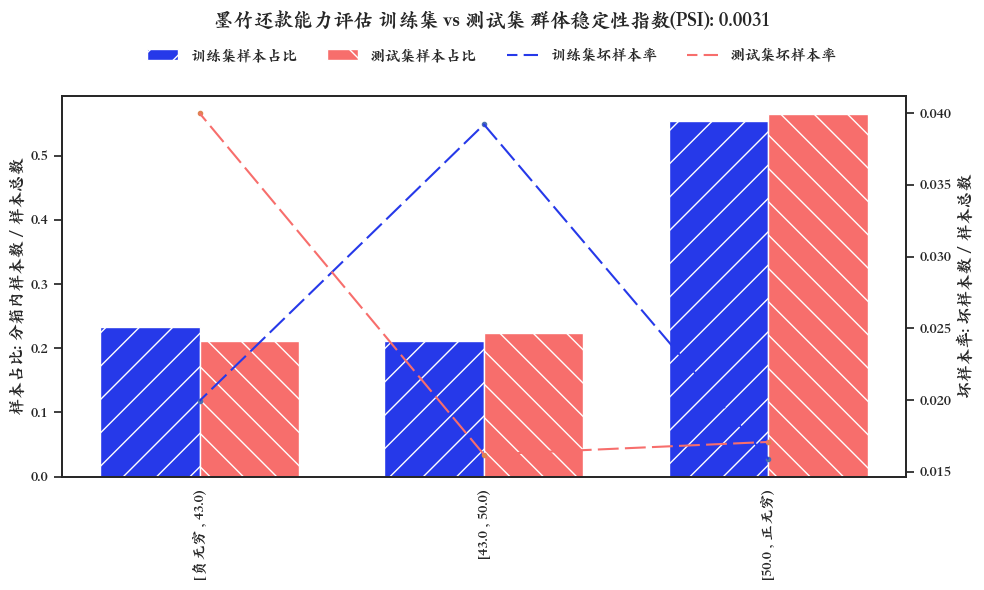

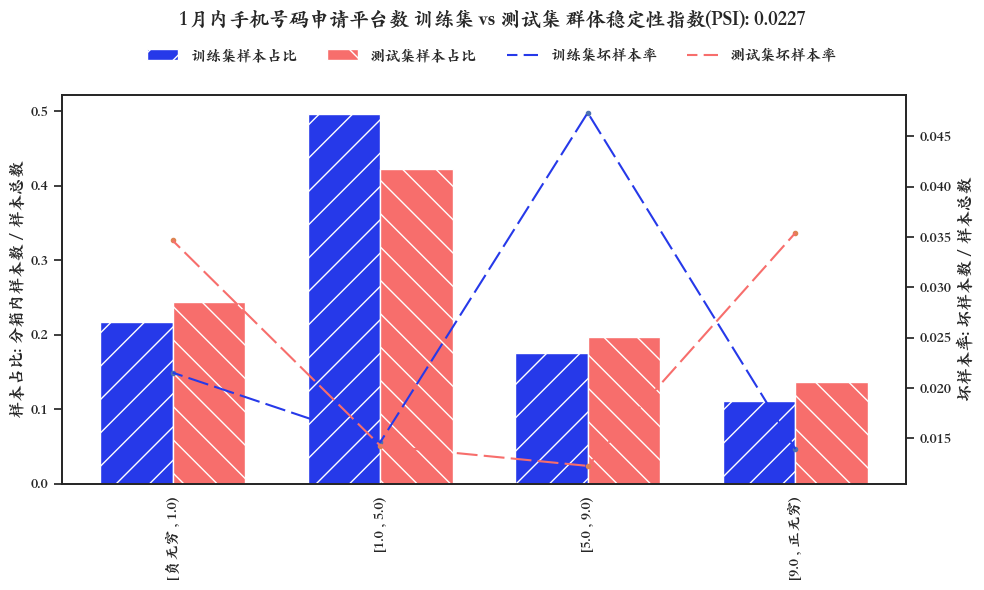

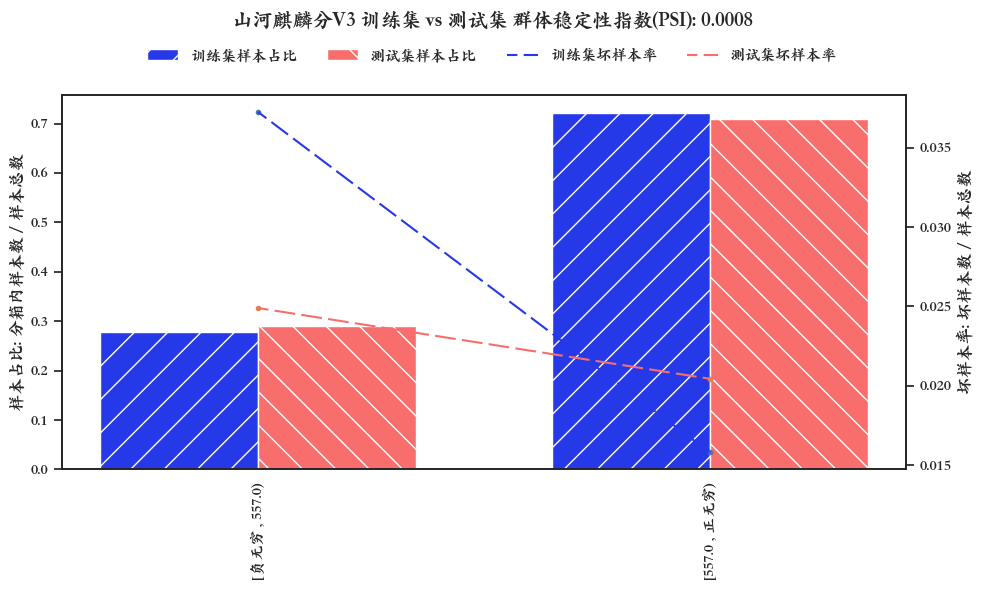

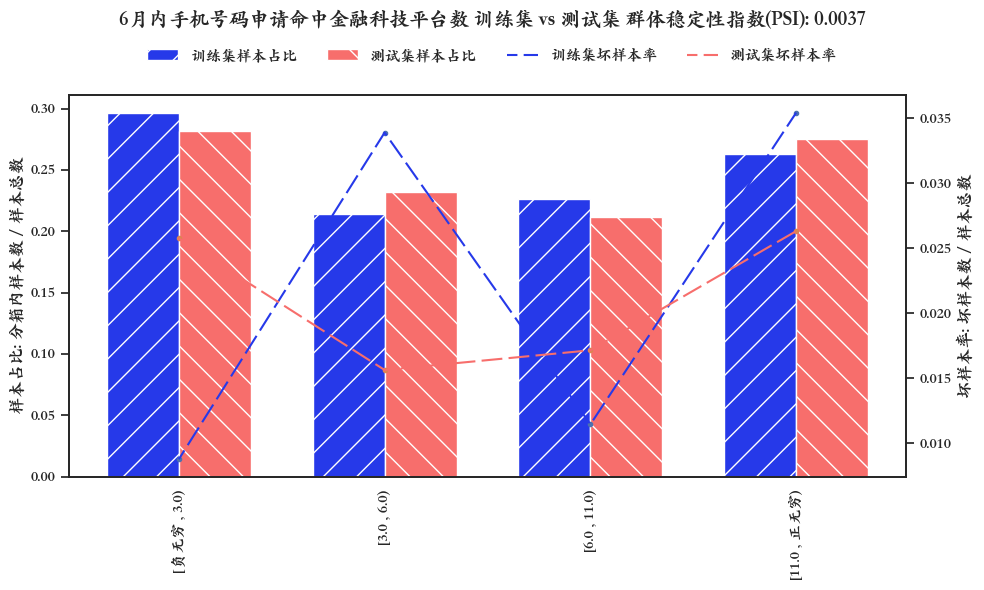

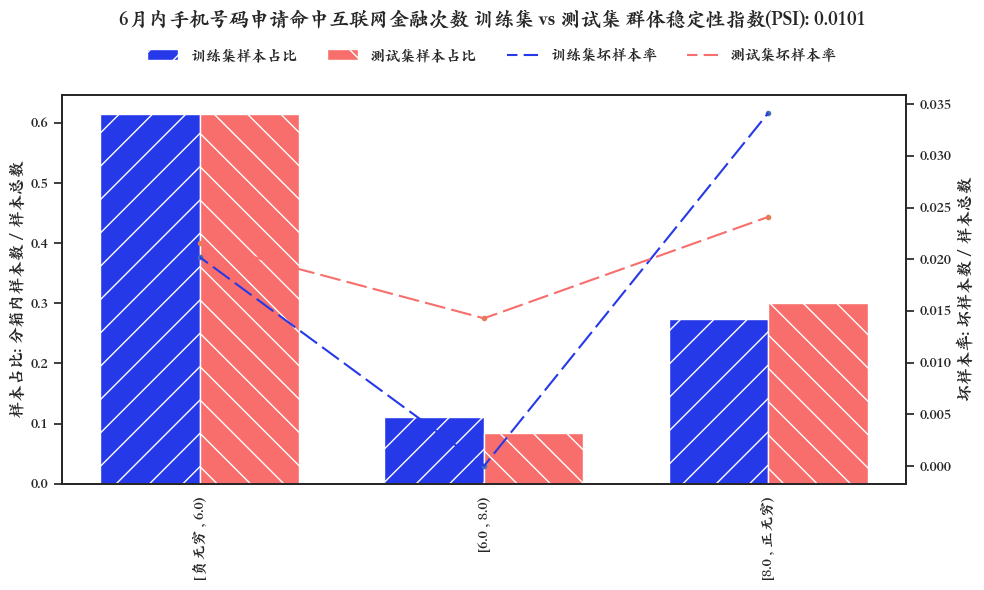

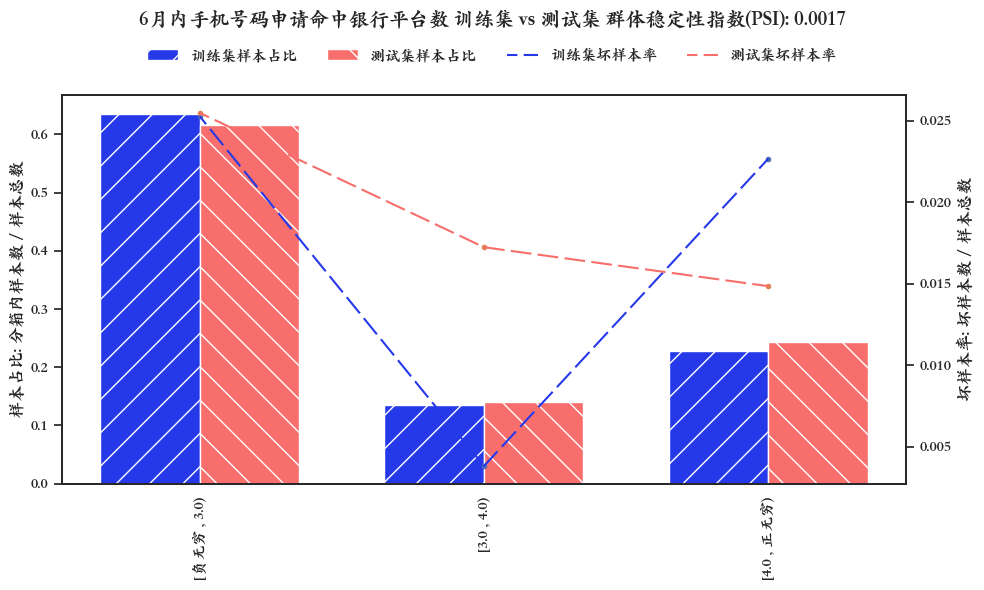

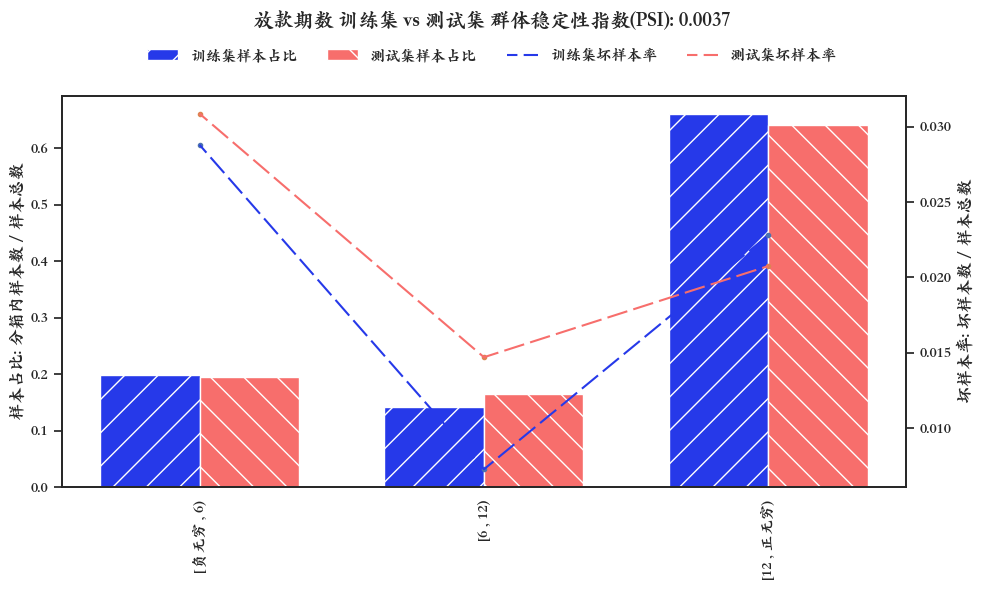

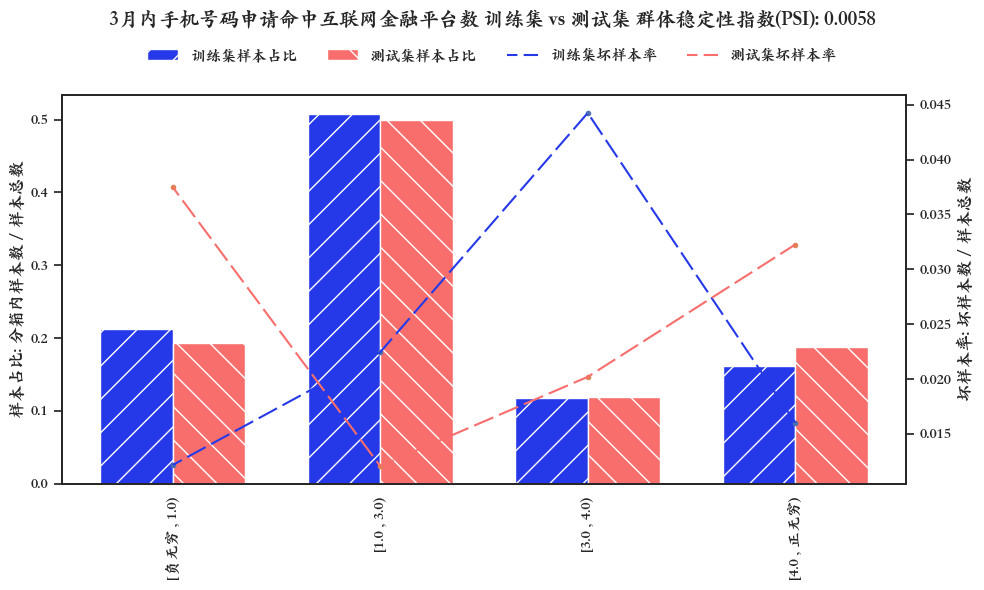

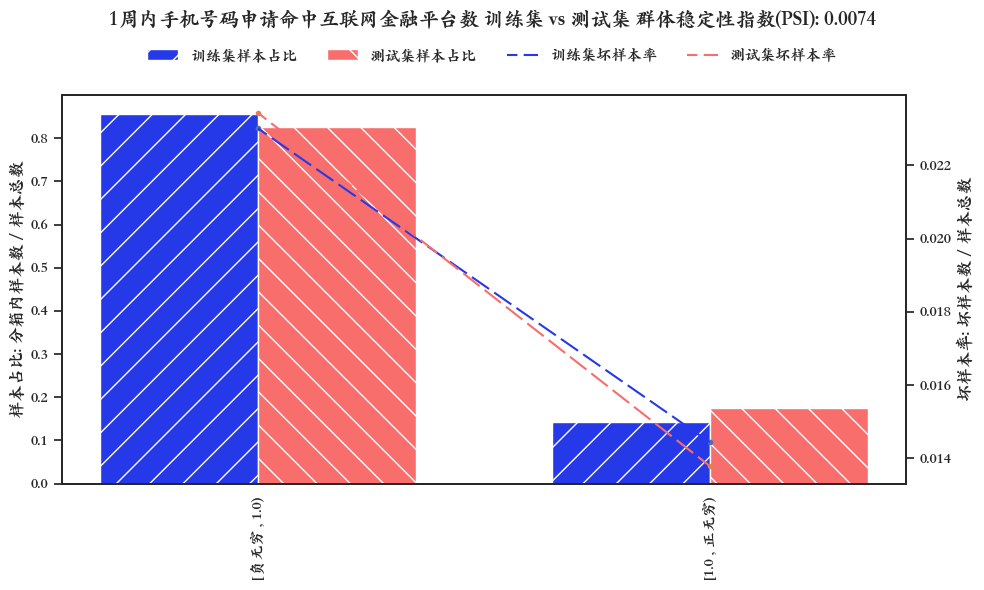

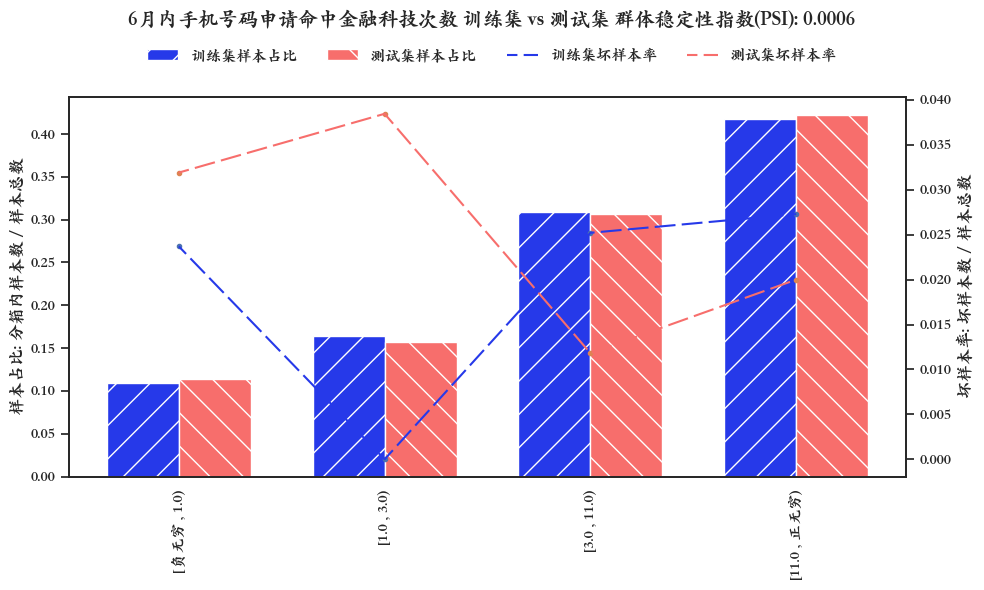

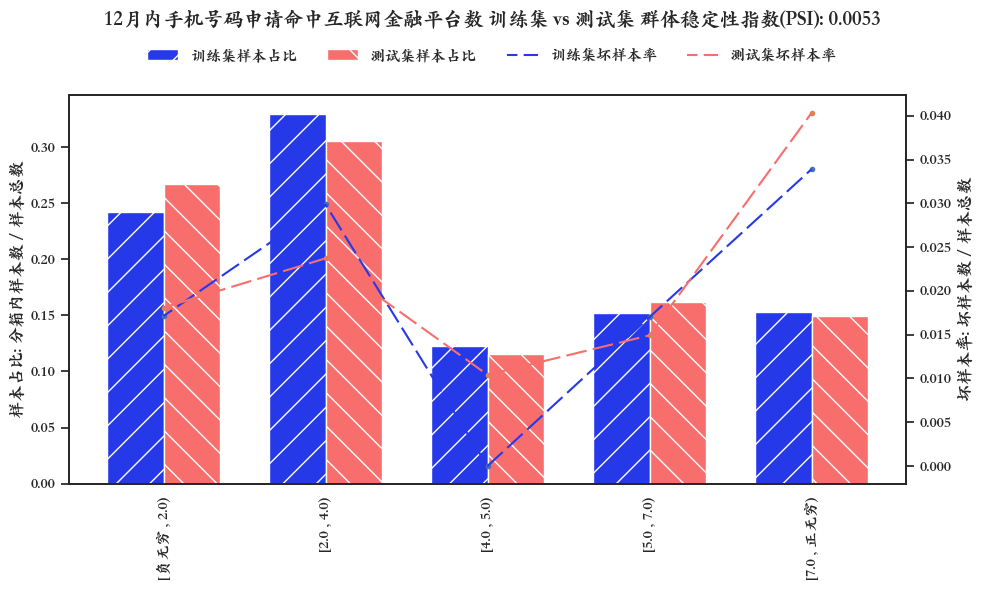

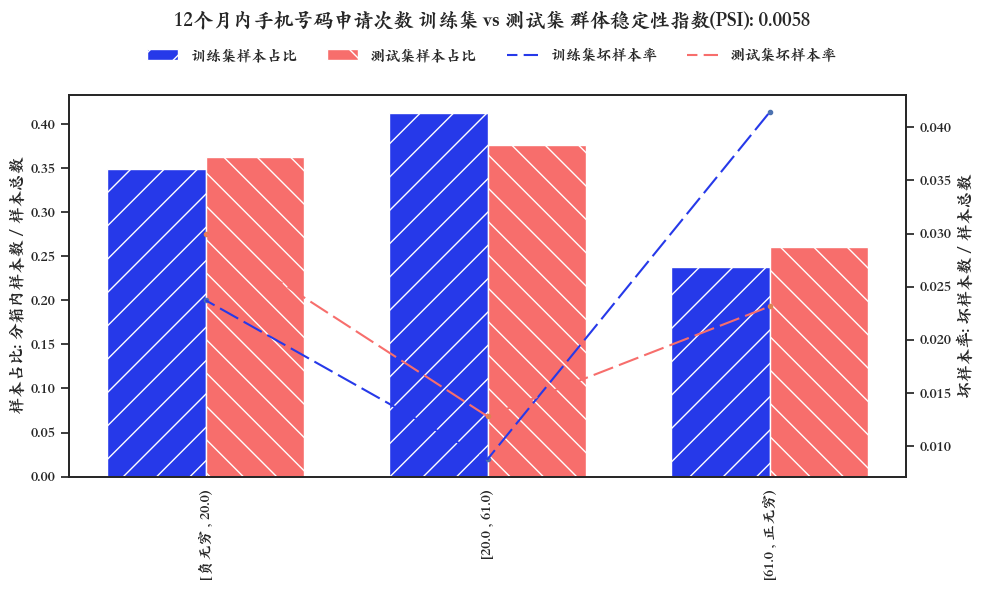

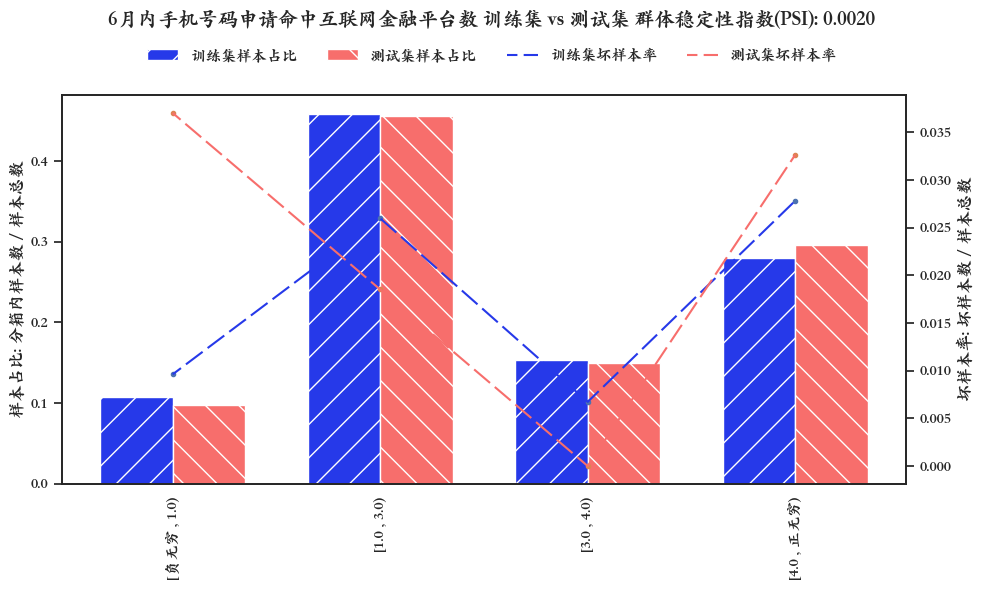

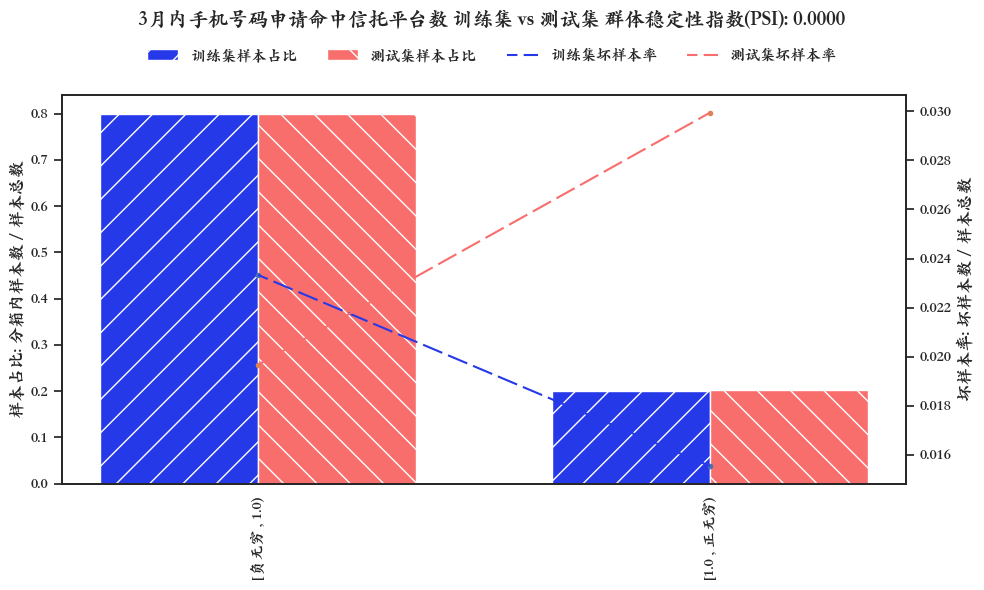

In [49]:
for col in card._feature_names:
    feature_table_train = sp.feature_bin_stats(train, col, target=target, desc=feature_map.get(col, "") or "逻辑回归入模变量", combiner=feature_pipeline.named_steps["combiner"])
    feature_table_test = sp.feature_bin_stats(test, col, target=target, desc=feature_map.get(col, "") or "逻辑回归入模变量", combiner=feature_pipeline.named_steps["combiner"])
    
    psi_table = sp.psi_plot(feature_table_train, feature_table_test, desc=col, result=True, plot=True, max_len=35, figsize=(10, 6), labels=["训练集", "测试集"])

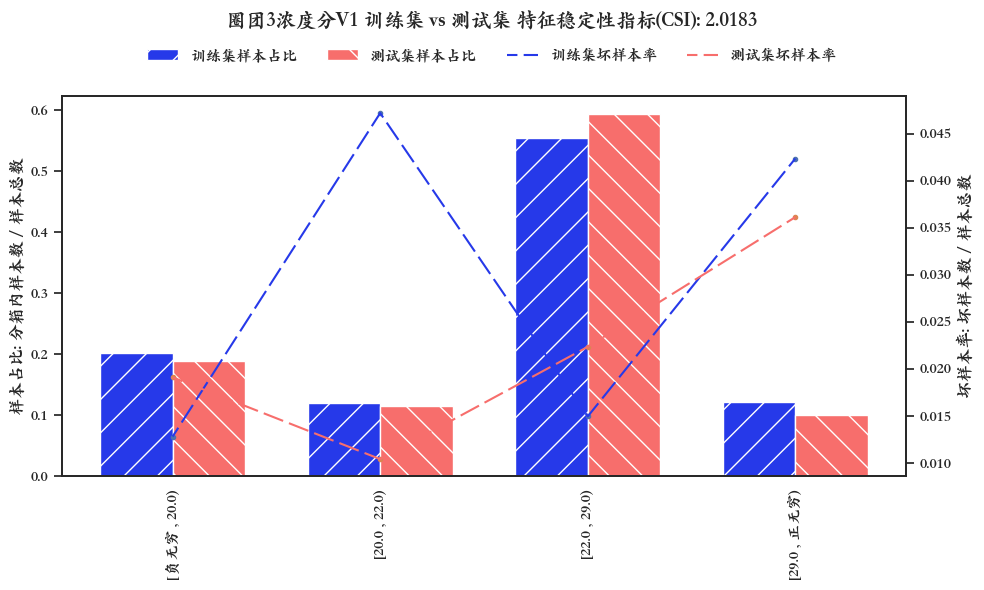

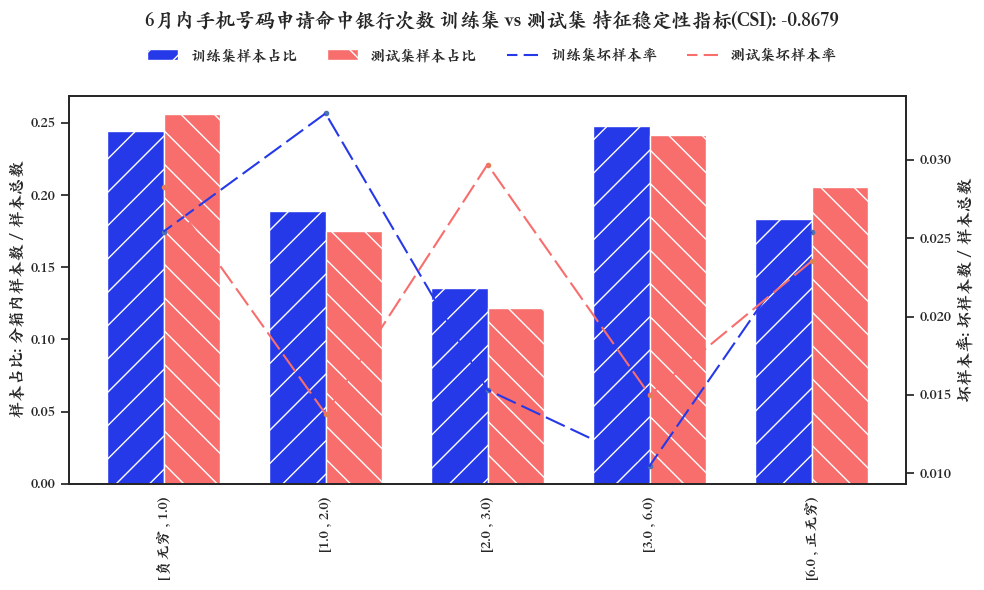

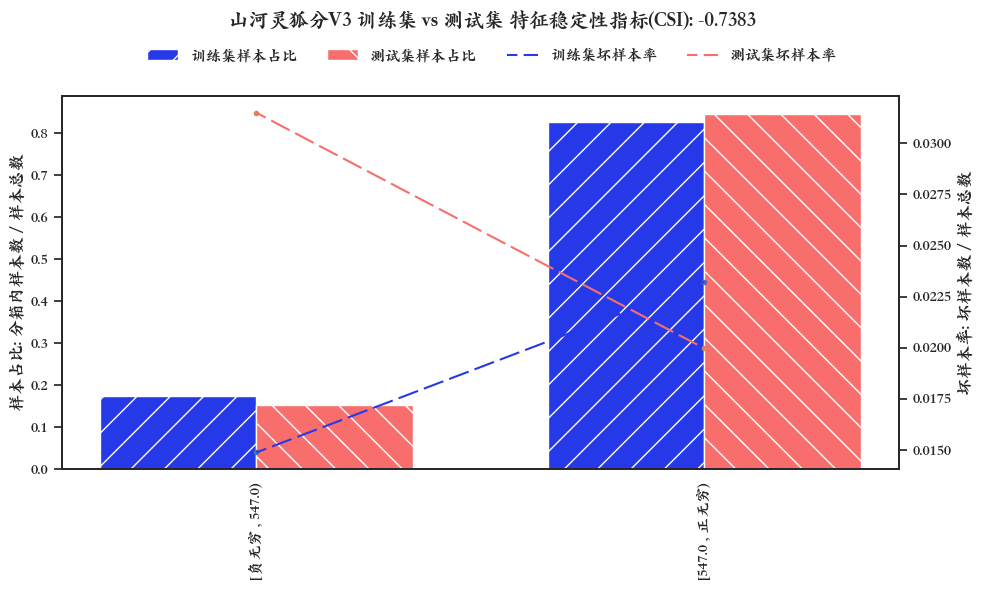

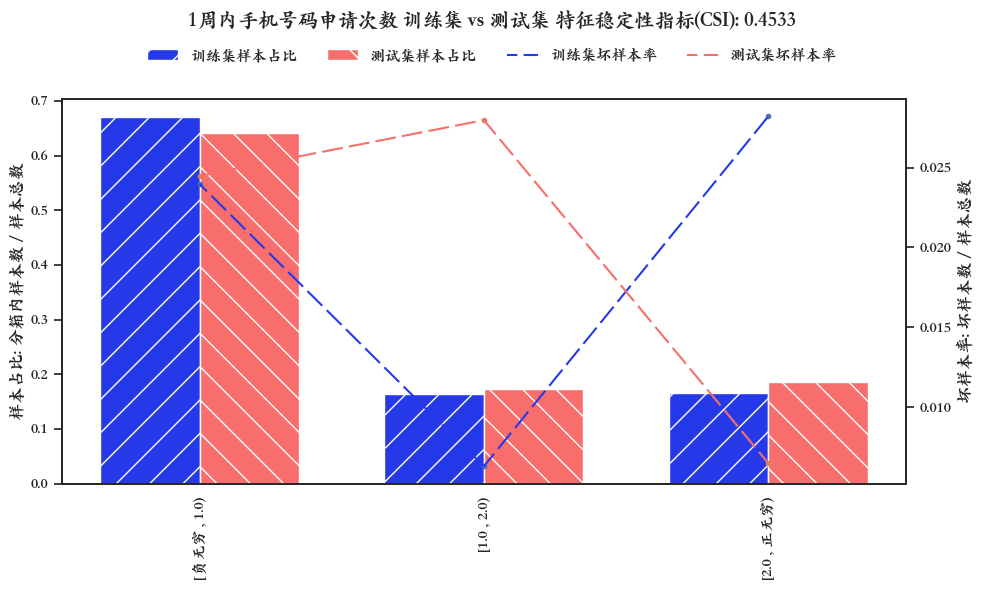

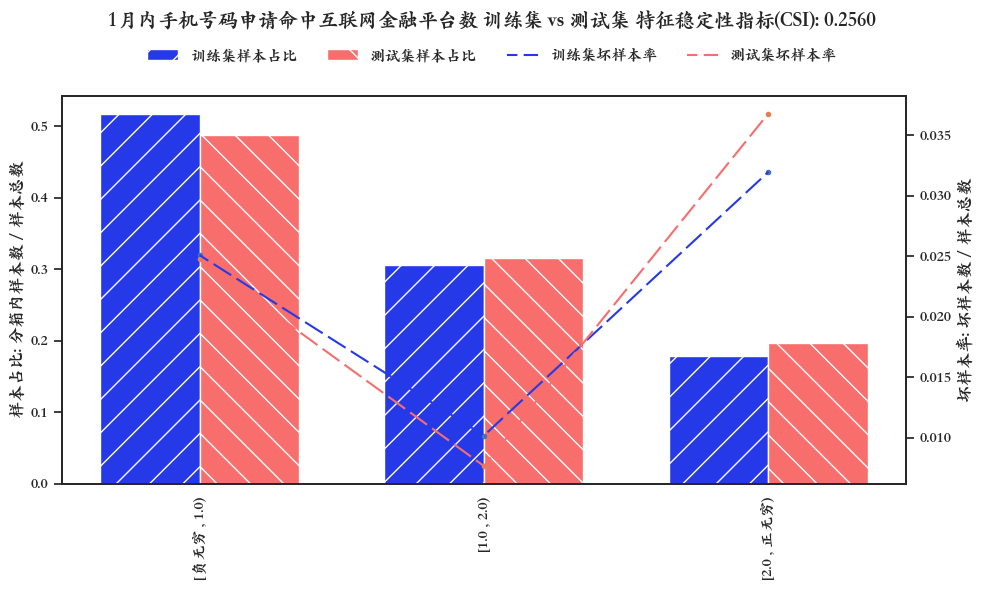

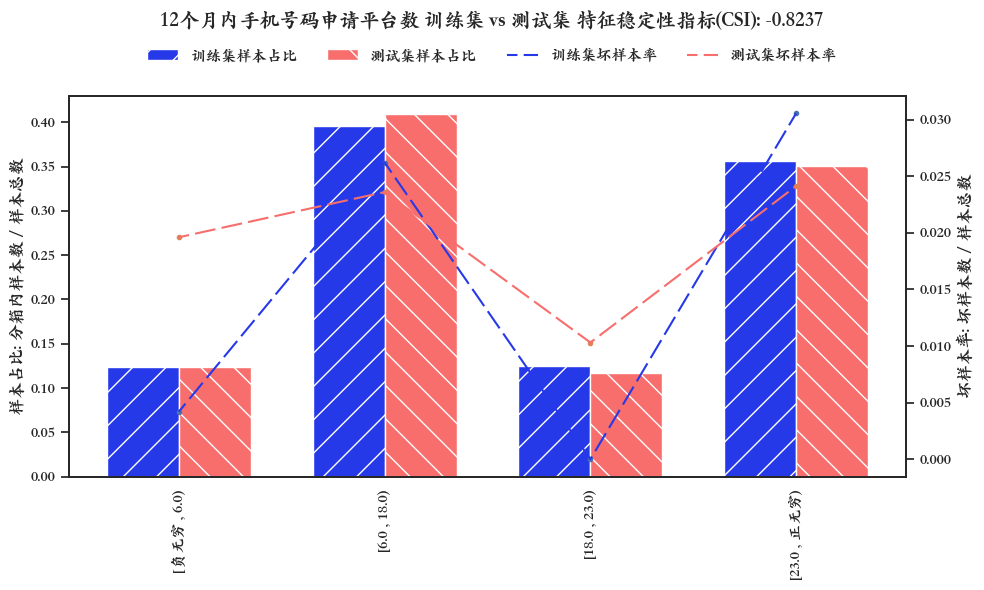

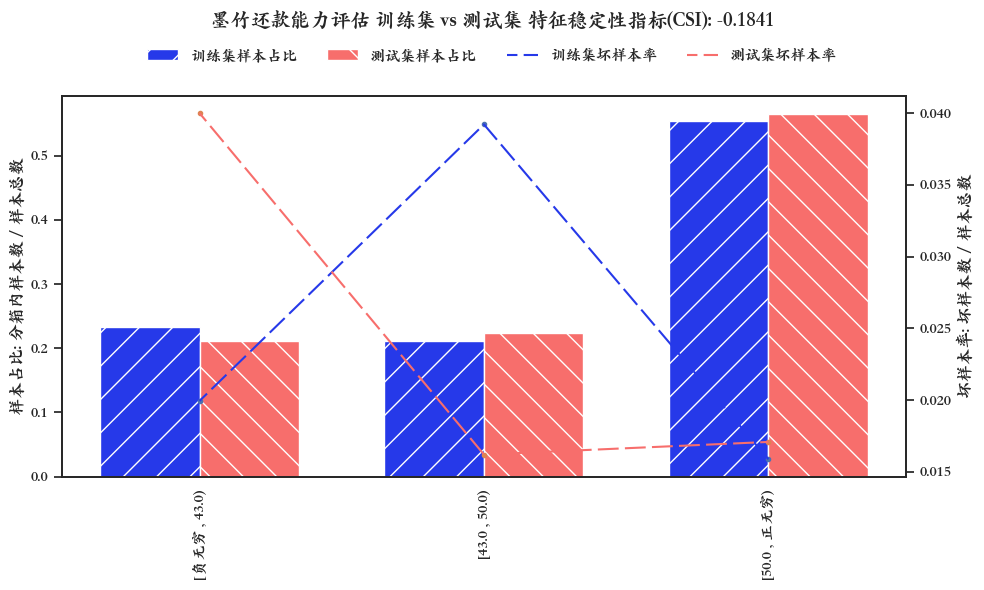

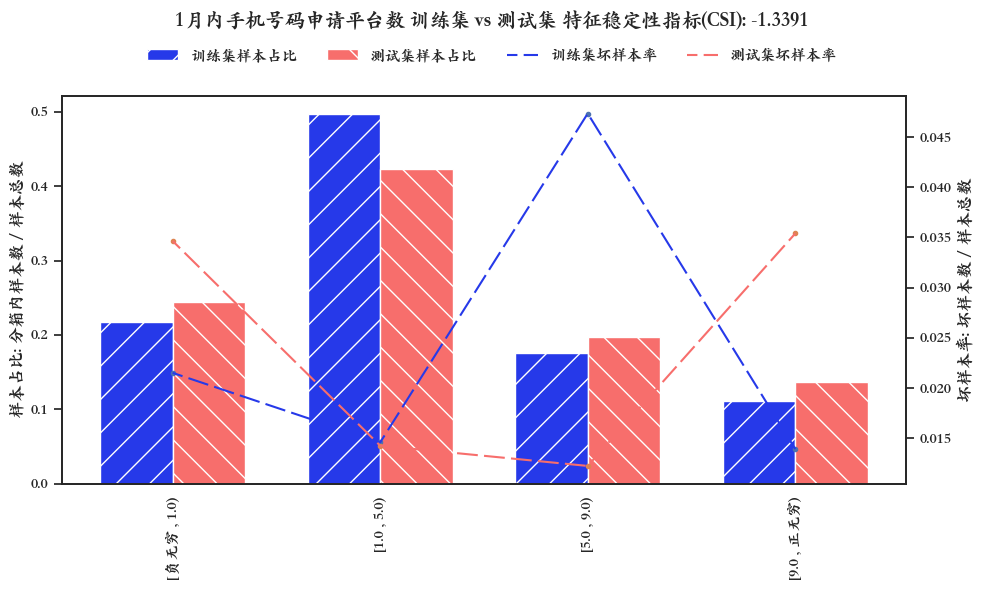

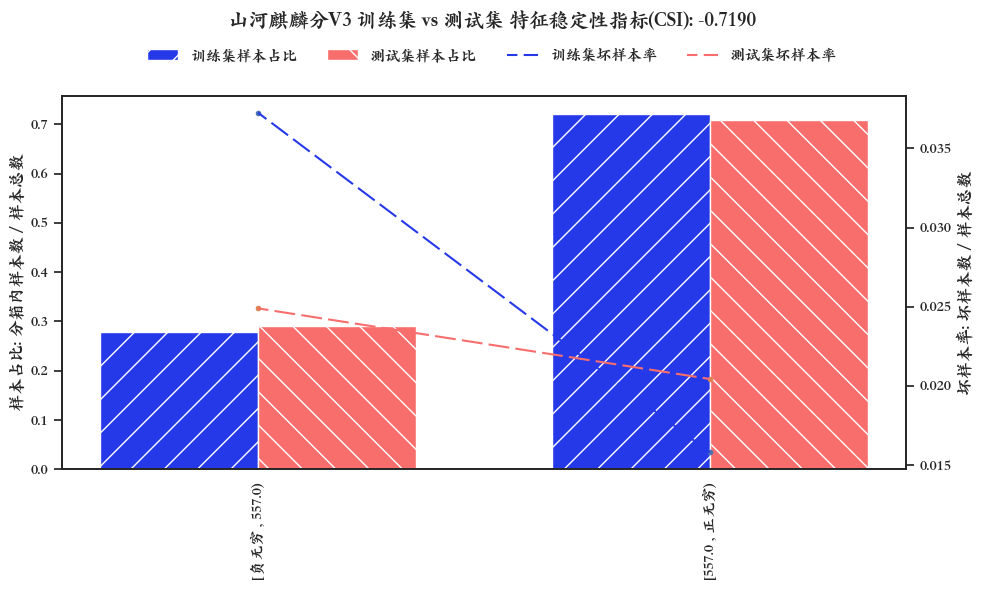

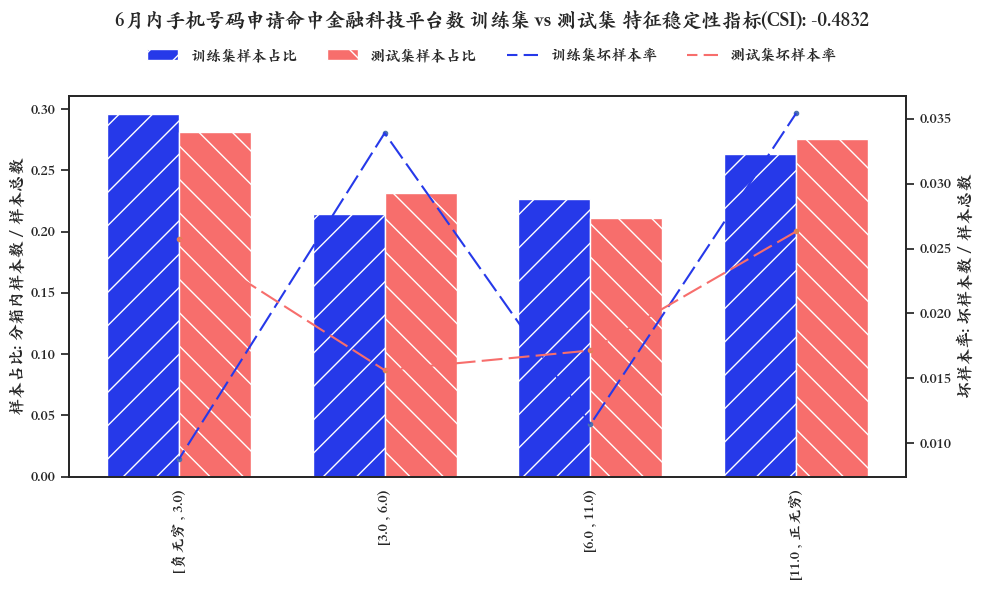

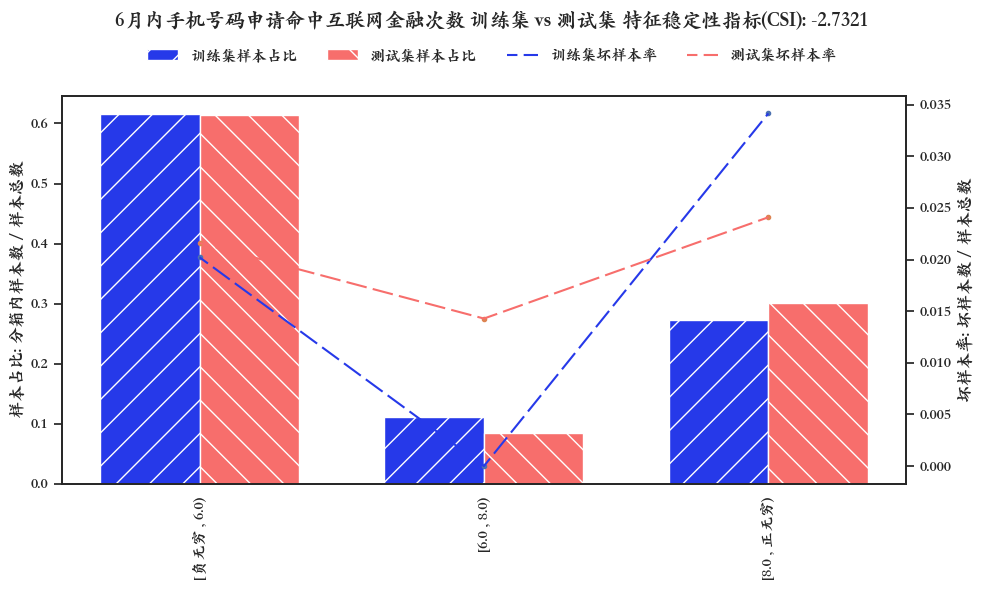

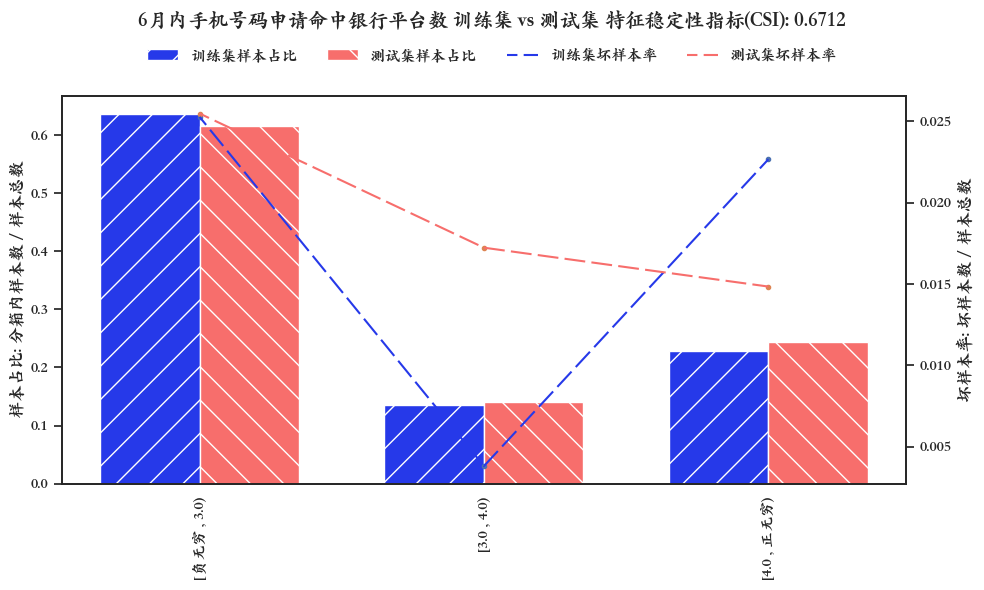

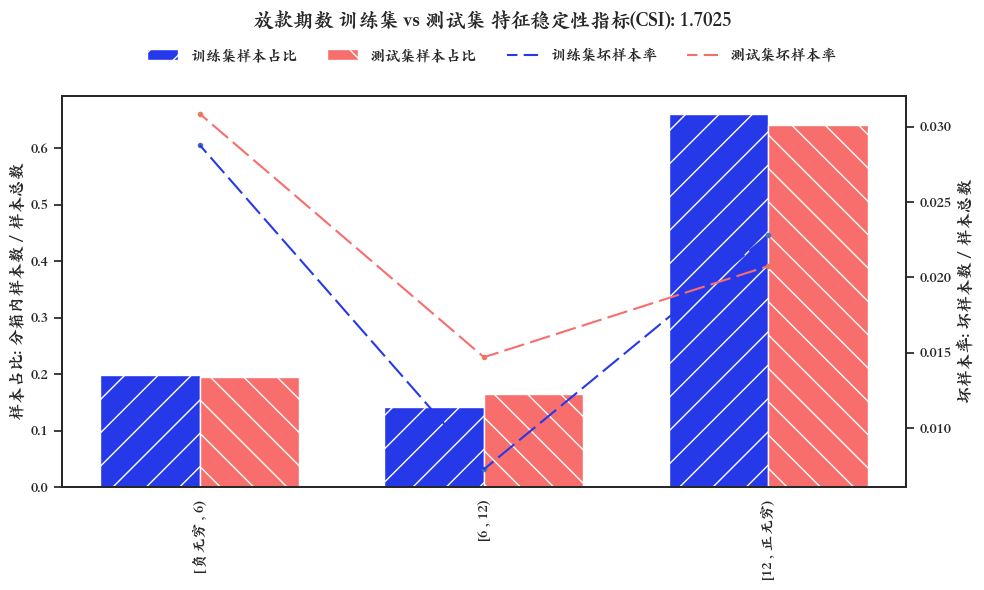

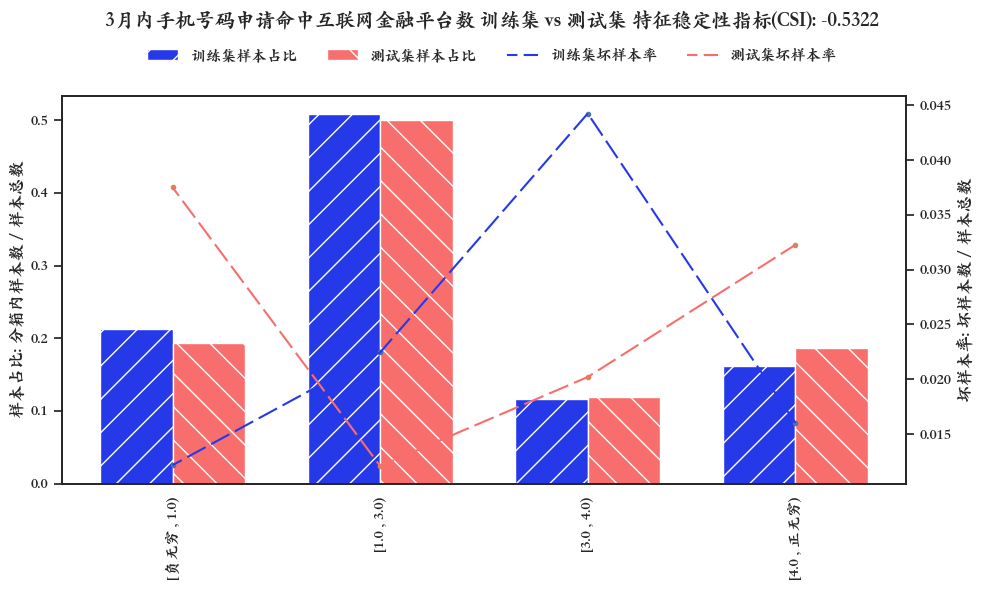

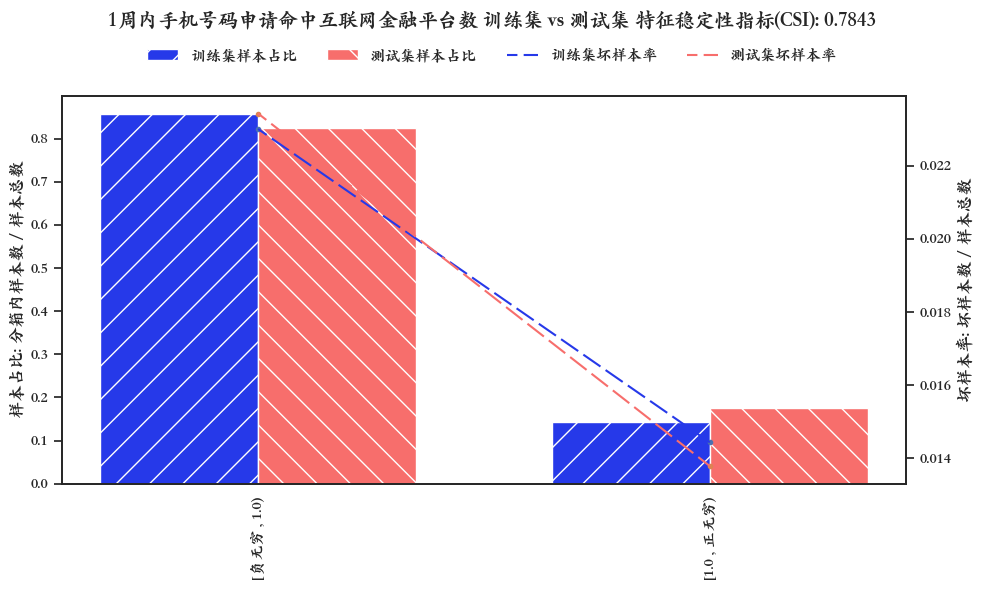

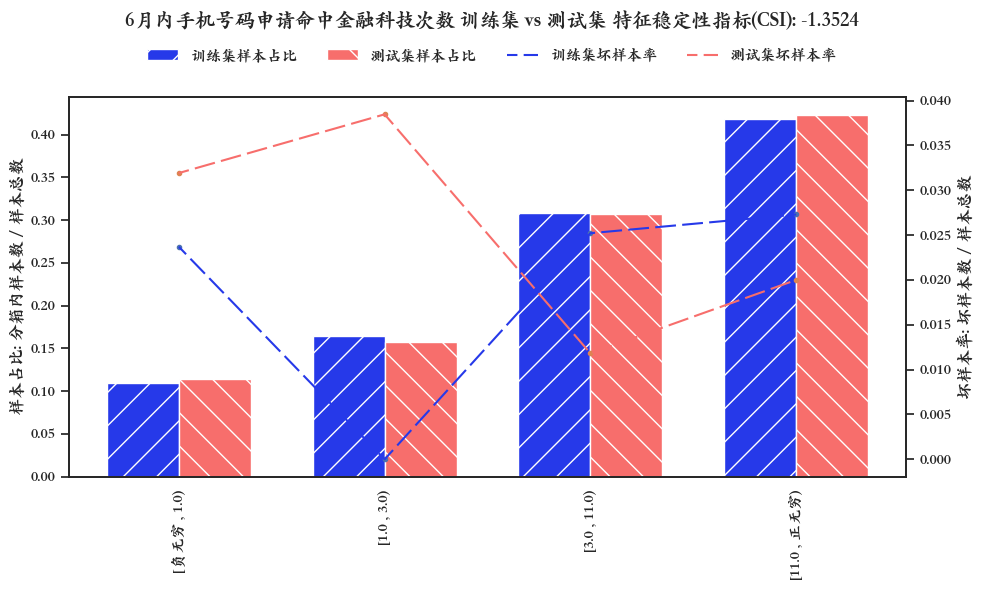

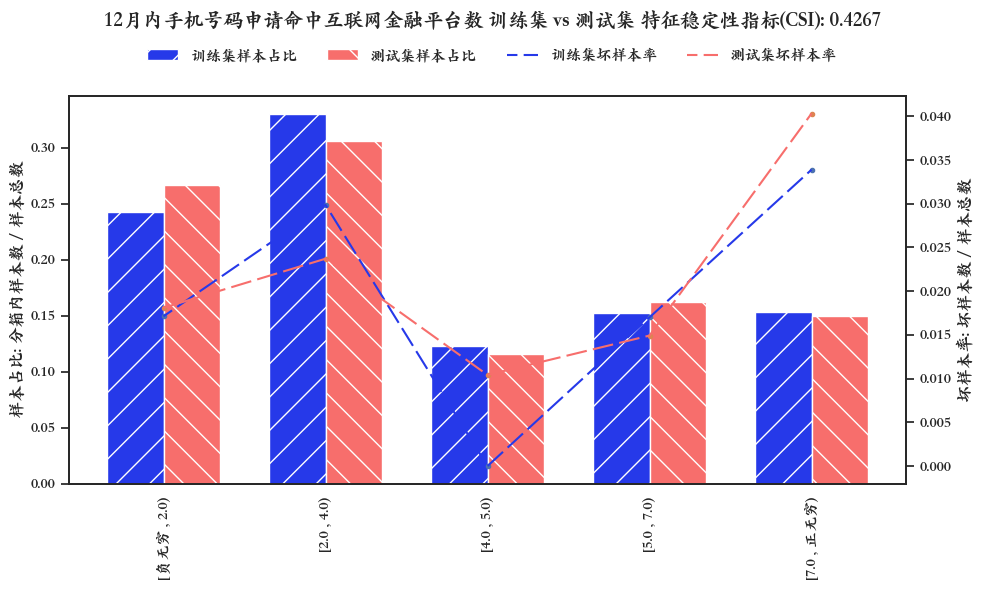

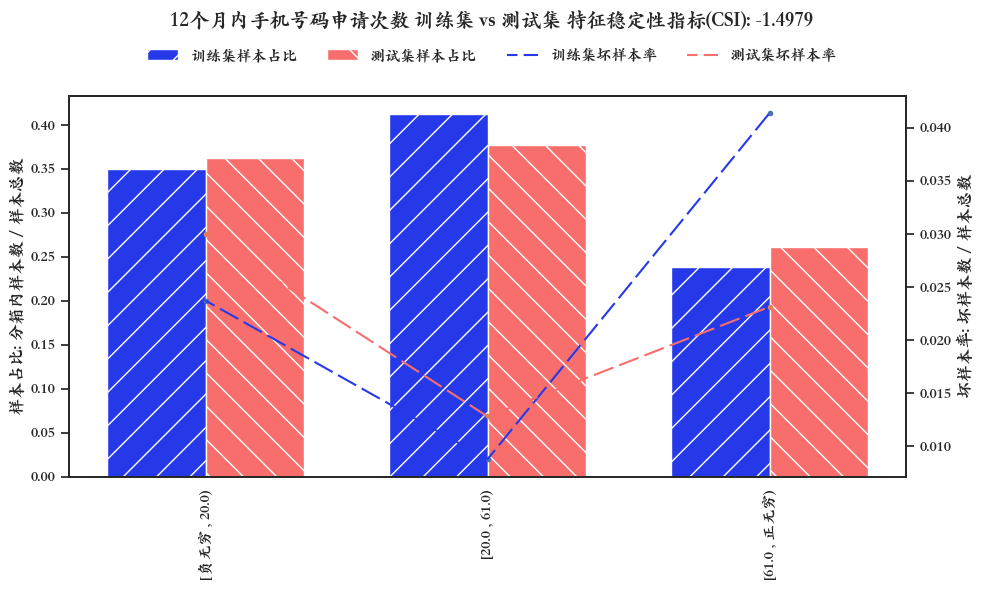

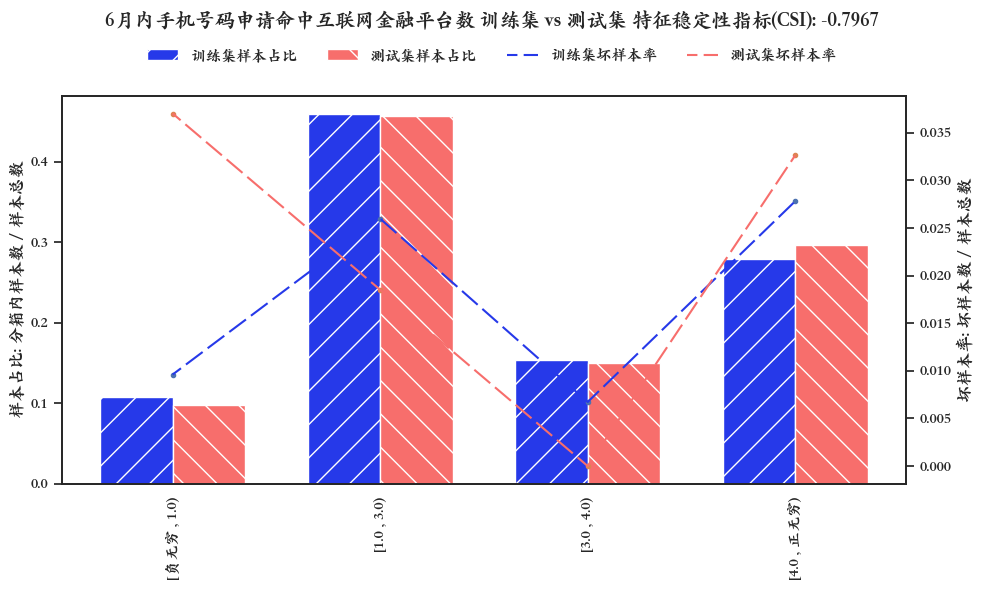

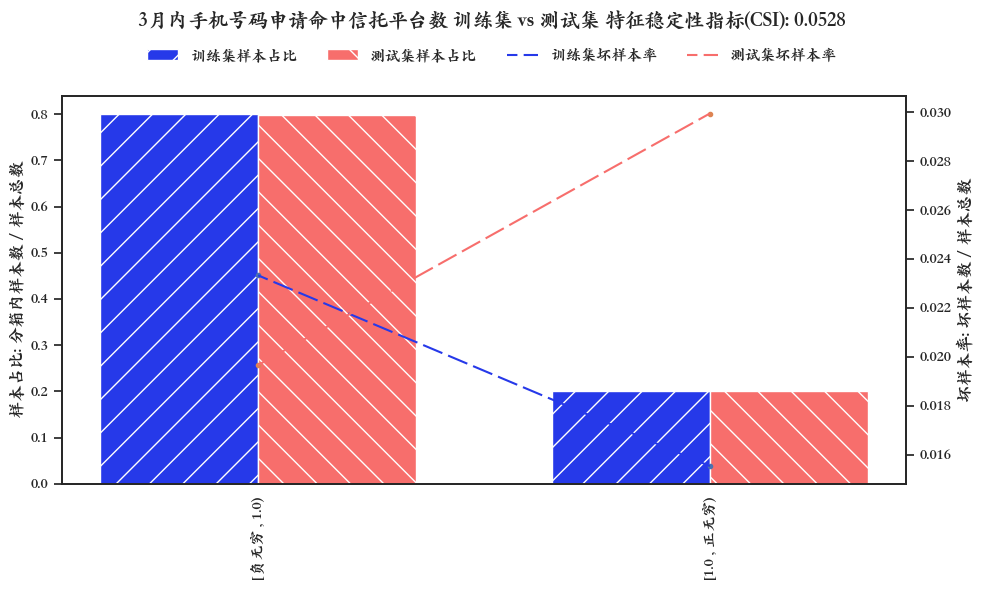

In [50]:
for col in card._feature_names:
    feature_table_train = sp.feature_bin_stats(train, col, target=target, desc=feature_map.get(col, "") or "逻辑回归入模变量", combiner=feature_pipeline.named_steps["combiner"])
    feature_table_test = sp.feature_bin_stats(test, col, target=target, desc=feature_map.get(col, "") or "逻辑回归入模变量", combiner=feature_pipeline.named_steps["combiner"])
    
    csi_table = sp.csi_plot(feature_table_train, feature_table_test, card[col], desc=col, result=True, plot=True, max_len=35, figsize=(10, 6), labels=["训练集", "测试集"])

In [51]:
sp.csi_plot?

Signature:
sp.csi_plot(
    expected,
    actual,
    score_bins,
    labels=['预期', '实际'],
    desc='',
    save=None,
    colors=['#2639E9', '#F76E6C', '#FE7715'],
    figsize=(15, 8),
    anchor=0.94,
    width=0.35,
    result=False,
    plot=True,
    max_len=None,
    hatch=True,
)
Docstring: <no docstring>
File:      ~/Desktop/workspace/scorecardpipeline/scorecardpipeline/utils.py
Type:      function

7.5 评分卡模型导出 pmml 文件

In [52]:
card.scorecard2pmml?

Signature: card.scorecard2pmml(pmml: str = 'scorecard.pmml', debug: bool = False)
Docstring:
export a scorecard to pmml

Args:
    pmml (str): io to write pmml file.
    debug (bool): If true, print information about the conversion process.
File:      ~/Desktop/workspace/scorecardpipeline/scorecardpipeline/model.py
Type:      method

In [53]:
scorecard_pipeline = card.scorecard2pmml(pmml="model_report/scorecard.pmml", debug=True)

python: 3.8.8
sklearn: 1.2.2
sklearn2pmml: 0.90.4
joblib: 1.2.0
sklearn_pandas: 2.2.0
pandas: 1.5.3
numpy: 1.22.2
java: 1.8.0_221
Executing command:
java -cp /Users/lubberit/anaconda3/lib/python3.8/site-packages/sklearn2pmml/resources/sklearn2pmml-1.0-SNAPSHOT.jar:/Users/lubberit/anaconda3/lib/python3.8/site-packages/sklearn2pmml/resources/gson-2.10.jar:/Users/lubberit/anaconda3/lib/python3.8/site-packages/sklearn2pmml/resources/guava-21.0.jar:/Users/lubberit/anaconda3/lib/python3.8/site-packages/sklearn2pmml/resources/h2o-genmodel-3.38.0.4.jar:/Users/lubberit/anaconda3/lib/python3.8/site-packages/sklearn2pmml/resources/h2o-logger-3.38.0.4.jar:/Users/lubberit/anaconda3/lib/python3.8/site-packages/sklearn2pmml/resources/h2o-tree-api-0.3.17.jar:/Users/lubberit/anaconda3/lib/python3.8/site-packages/sklearn2pmml/resources/istack-commons-runtime-4.0.1.jar:/Users/lubberit/anaconda3/lib/python3.8/site-packages/sklearn2pmml/resources/jackson-annotations-2.13.3.jar:/Users/lubberit/anaconda3/lib

In [61]:
scorecard_pipeline[0].feature

AttributeError: 'DataFrameMapper' object has no attribute 'feature'

In [55]:
from pypmml import Model

pmml_card = Model.fromFile("model_report/scorecard.pmml")
pd.DataFrame({"PMML": pmml_card.predict(test)["predicted_score"].tolist(), "SCORECARDPIPELINE": test["score"].tolist()})

AttributeError: 'Timestamp' object has no attribute '_get_object_id'

8 `pipeline` 超参数搜索

In [ ]:
# 训练集 & 测试集数据，为了不影响 第9节 输出评分卡模型报告，这一节重新加载下数据并且变量命名全部以 _ 开始
_data = sp.germancredit()
_data[target] = _data[target].map({"good": 0, "bad": 1})
_train, _test = train_test_split(_data, test_size=0.3, shuffle=True, stratify=_data[target])

In [ ]:
# 构建 pipeline
_model_pipeline = sp.Pipeline([
    ("preprocessing_select", sp.FeatureSelection(target=target, engine="toad")),
    ("combiner", sp.Combiner(target=target, min_bin_size=0.2)),
    ("transform", sp.WOETransformer(target=target)),
    ("processing_select", sp.FeatureSelection(target=target, engine="toad")),
    ("stepwise", sp.StepwiseSelection(target=target)),
    ("logistic", sp.ITLubberLogisticRegression(target=target)),
])

_model_pipeline

Pipeline(steps=[('preprocessing_select',
                 FeatureSelection(engine='toad', target='creditability')),
                ('combiner',
                 Combiner(min_bin_size=0.2, target='creditability')),
                ('transform',
                 WOETransformer(exclude=[], target='creditability')),
                ('processing_select',
                 FeatureSelection(engine='toad', target='creditability')),
                ('stepwise', StepwiseSelection(target='creditability')),
                ('logistic',
                 ITLubberLogisticRegression(target='creditability'))])

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
_params_grid = {
    "combiner__max_n_bins": [3],
    "logistic__C": [np.power(2, i) for i in range(5)],
    "logistic__penalty": ["l2"],
    "logistic__class_weight": [None, "balanced"] + [{1: i / 10.0, 0: 1 - i / 10.0} for i in range(1, 10, 2)],
    "logistic__max_iter": [10, 50, 100],
    "logistic__solver": ["sag"], # ["liblinear", "sag", "lbfgs", "newton-cg"],
}

_pipeline_grid_search = GridSearchCV(_model_pipeline, _params_grid, cv=3, scoring='roc_auc', verbose=1, n_jobs=-1, return_train_score=True)
_pipeline_grid_search.fit(_train, _train[target])

logger.info(_pipeline_grid_search.best_params_)

Fitting 3 folds for each of 105 candidates, totalling 315 fits


[ 2023-10-13 17:49:51,056 ][ INFO ][ 3098908083.py:<module>:13 ] {'combiner__max_n_bins': 3, 'logistic__C': 1, 'logistic__class_weight': None, 'logistic__max_iter': 10, 'logistic__penalty': 'l2', 'logistic__solver': 'sag'}


In [ ]:
_model_pipeline.set_params(**_pipeline_grid_search.best_params_)
_model_pipeline.fit(_train)

Pipeline(steps=[('preprocessing_select',
                 FeatureSelection(engine='toad', target='creditability')),
                ('combiner',
                 Combiner(max_n_bins=3, min_bin_size=0.2,
                          target='creditability')),
                ('transform',
                 WOETransformer(exclude=[], target='creditability')),
                ('processing_select',
                 FeatureSelection(engine='toad', target='creditability')),
                ('stepwise', StepwiseSelection(target='creditability')),
                ('logistic',
                 ITLubberLogisticRegression(C=1, max_iter=10, solver='sag',
                                            target='creditability'))])

In [ ]:
_y_pred_train = _model_pipeline.predict(_train.drop(columns=[target]))
_y_pred_test = _model_pipeline.predict(_test.drop(columns=[target]))

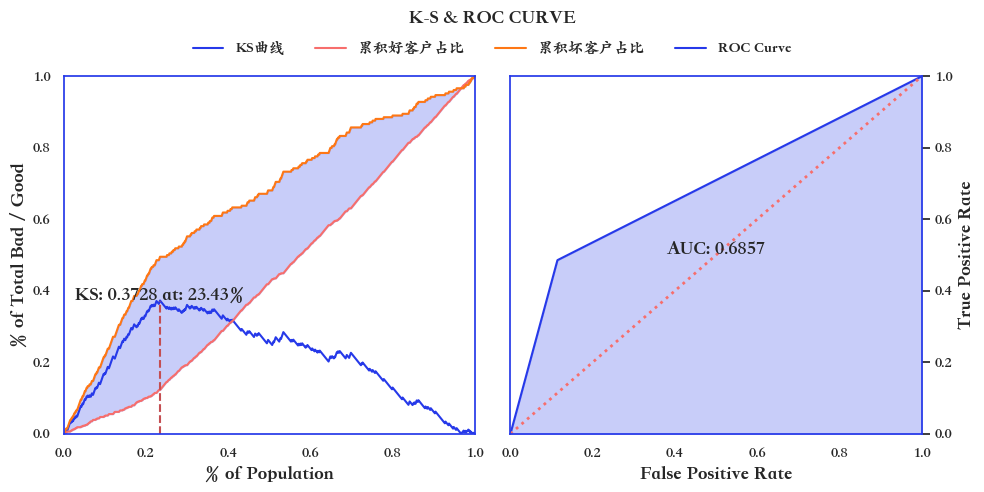

In [ ]:
_ = sp.ks_plot(_y_pred_train, _train[target], figsize=(10, 5))

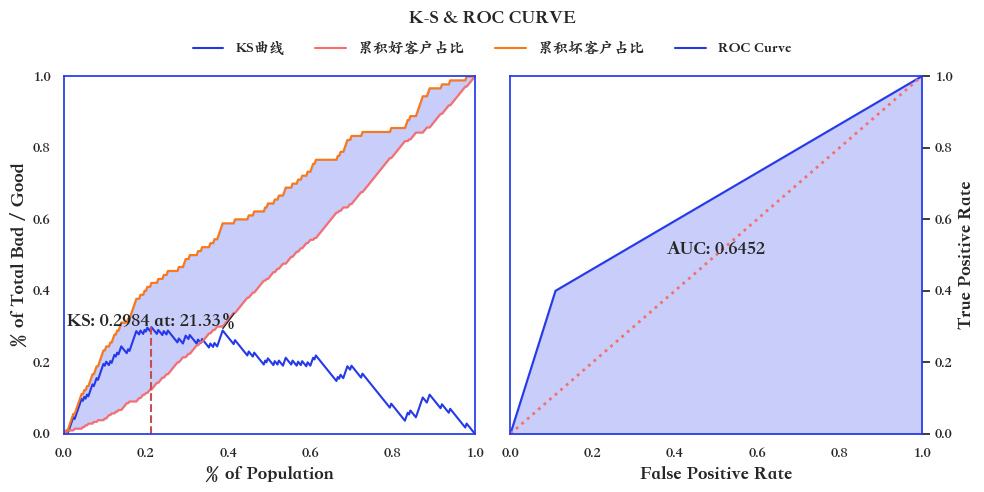

In [ ]:
_ = sp.ks_plot(_y_pred_test, _test[target], figsize=(10, 5))

In [ ]:
_woe_train = _model_pipeline[:-1].transform(train)

_card = sp.ScoreCard(target=target, pipeline=_model_pipeline)
_card.fit(_woe_train)

_card.scorecard_points()

变量名称  \
0                   status_of_existing_checking_account   
1                   status_of_existing_checking_account   
2                   status_of_existing_checking_account   
3                                     duration_in_month   
4                                     duration_in_month   
5                                     duration_in_month   
6                                        credit_history   
7                                        credit_history   
8                                        credit_history   
9                                               purpose   
10                                              purpose   
11                                              purpose   
12                                        credit_amount   
13                                        credit_amount   
14                                        credit_amount   
15                            savings_account_and_bonds   
16                            savings_account_and_bonds   
17                            savings_account_and_bonds   
18  installment_rate_in_percentage_of_disposable_income   
19  installment_rate_in_percentage_of_disposable_income   
20  installment_rate_in_percentage_of_disposable_income   
21                          other_debtors_or_guarantors   
22                          other_debtors_or_guarantors   
23                          other_debtors_or_guarantors   
24                                         age_in_years   
25                                         age_in_years   
26                                         age_in_years   
27                              other_installment_plans   
28                              other_installment_plans   
29                              other_installment_plans   
30                                              housing   
31                                              housing   
32                                              housing   

                                                                                    变量分箱  \
0                                                                    no checking account   
1               ... >= 200 DM / salary assignments for at least 1 year,0 <= ... < 200 DM   
2                                                                             ... < 0 DM   
3                                                                            [-inf ~ 16)   
4                                                                              [16 ~ 45)   
5                                                                             [45 ~ inf)   
6                            critical account/ other credits existing (not at this bank)   
7               existing credits paid back duly till now,delay in paying off in the past   
8   all credits at this bank paid back duly,no credits taken/ all credits paid back duly   
9                                                 retraining,car (used),radio/television   
10                    repairs,furniture/equipment,domestic appliances,business,education   
11                                                                      car (new),others   
12                                                                         [-inf ~ 1374)   
13                                                                         [1374 ~ 3914)   
14                                                                          [3914 ~ inf)   
15                                                   ... >= 1000 DM,500 <= ... < 1000 DM   
16                                                           unknown/ no savings account   
17                                                      100 <= ... < 500 DM,... < 100 DM   
18                                                                            [-inf ~ 2)   
19                                                                               [2 ~ 4)   
20                                                                             [4 ~ inf)   
21                  

9 模型报告输出

In [ ]:
sp.ExcelWriter?

Init signature:
sp.ExcelWriter(
    style_excel='/Users/lubberit/Desktop/workspace/scorecardpipeline/scorecardpipeline/template.xlsx',
    style_sheet_name='初始化',
    mode='replace',
    fontsize=10,
    font='楷体',
    theme_color='2639E9',
    opacity=0.85,
)
Docstring:      <no docstring>
Init docstring:
excel 文件内容写入公共方法

:param style_excel: 样式模版文件，默认当前路径下的 template.xlsx ，如果项目路径调整需要进行相应的调整
:param style_sheet_name: 模版文件内初始样式sheet名称，默认即可
:param fontsize: 插入excel文件中内容的字体大小，默认 10
:param font: 插入excel文件中内容的字体，默认 楷体
:param theme_color: 主题色，默认 2639E9，注意不包含 #
:param opacity: 写入dataframe时使用颜色填充主题色的透明度设置，默认 0.85
File:           ~/Desktop/workspace/scorecardpipeline/scorecardpipeline/excel_writer.py
Type:           type
Subclasses:     

In [ ]:
sp.ExcelWriter.insert_value2sheet?

Signature:
sp.ExcelWriter.insert_value2sheet(
    self,
    worksheet,
    insert_space,
    value='',
    style='content',
    auto_width=False,
)
Docstring:
向sheet中的某个单元格插入某种样式的内容

:param worksheet: 需要插入内容的sheet
:param insert_space: 内容插入的单元格位置，可以是 "B2" 或者 (2, 2) 任意一种形式
:param value: 需要插入的内容
:param style: 渲染的样式，参考 init_style 中初始设置的样式
:param auto_width: 是否开启自动调整列宽
:return 返回插入元素最后一列之后、最后一行之后的位置
File:      ~/Desktop/workspace/scorecardpipeline/scorecardpipeline/excel_writer.py
Type:      function

In [ ]:
sp.ExcelWriter.insert_pic2sheet?

Signature:
sp.ExcelWriter.insert_pic2sheet(
    self,
    worksheet,
    fig,
    insert_space,
    figsize=(600, 250),
)
Docstring:
向excel中插入图片内容

:param worksheet: 需要插入内容的sheet
:param fig: 需要插入的图片路径
:param insert_space: 插入图片的起始单元格
:param figsize: 图片大小设置
:return 返回插入元素最后一列之后、最后一行之后的位置
File:      ~/Desktop/workspace/scorecardpipeline/scorecardpipeline/excel_writer.py
Type:      function

In [ ]:
sp.ExcelWriter.insert_df2sheet?

Signature:
sp.ExcelWriter.insert_df2sheet(
    self,
    worksheet,
    data,
    insert_space,
    merge_column=None,
    header=True,
    index=False,
    auto_width=False,
    fill=False,
    merge=False,
)
Docstring:
向excel文件中插入指定样式的dataframe数据

:param worksheet: 需要插入内容的sheet
:param data: 需要插入的dataframe
:param insert_space: 插入内容的起始单元格位置
:param merge_column: 需要分组显示的列，index或者列名
:param header: 是否存储dataframe的header，暂不支持多级表头
:param index: 是否存储dataframe的index
:param auto_width: 是否自动调整列宽
:param fill: 是否使用颜色填充而非边框
:param merge: 是否合并单元格，配合 merge_column 一起使用，当前版本仅在 merge_column 只有一列时有效

返回插入元素最后一列之后、最后一行之后的位置
File:      ~/Desktop/workspace/scorecardpipeline/scorecardpipeline/excel_writer.py
Type:      function

In [ ]:
sp.ExcelWriter.add_conditional_formatting?

Signature:
sp.ExcelWriter.add_conditional_formatting(
    self,
    worksheet,
    start_space,
    end_space,
)
Docstring:
设置条件格式

:param worksheet: 当前选择设置条件格式的sheet
:param start_space: 开始单元格位置
:param end_space: 结束单元格位置
File:      ~/Desktop/workspace/scorecardpipeline/scorecardpipeline/excel_writer.py
Type:      function

In [ ]:
sp.ExcelWriter.set_number_format?

Signature: sp.ExcelWriter.set_number_format(worksheet, space, _format)
Docstring:
设置数值显示格式

:param worksheet: 当前选择调整数值显示格式的sheet
:param space: 单元格范围
:param _format: 显示格式，参考 openpyxl
File:      ~/Desktop/workspace/scorecardpipeline/scorecardpipeline/excel_writer.py
Type:      function

In [ ]:
sp.dataframe2excel?

Signature:
sp.dataframe2excel(
    data,
    excel_writer,
    sheet_name=None,
    title=None,
    header=True,
    theme_color='2639E9',
    fill=True,
    percent_cols=None,
    condition_cols=None,
    custom_cols=None,
    custom_format='#,##0',
    color_cols=None,
    start_col=2,
    start_row=2,
    mode='replace',
    writer_params={},
    **kwargs,
)
Docstring:
向excel文件中插入指定样式的dataframe数据

:param data: 需要保存的dataframe数据，index默认不保存，如果需要保存先 .reset_index().rename(columns={"index": "索引名称"}) 再保存，有部分索引 reset_index 之后是 0 而非 index，根据实际情况进行修改
:param excel_writer: 需要保存到的 excel 文件路径或者 ExcelWriter
:param sheet_name: 需要插入内容的sheet，如果是 Worksheet，则直接向 Worksheet 插入数据
:param title: 是否在dataframe之前的位置插入一个标题
:param header: 是否存储dataframe的header，暂不支持多级表头
:param theme_color: 主题色
:param fill: 是否使用单元个颜色填充样式还是使用边框样式
:param percent_cols: 需要显示为百分数的列，仅修改显示格式，不更改数值
:param condition_cols: 需要显示条件格式的列（无边框渐变数据条）
:param color_cols: 需要显示为条件格式颜色填充的列（单元格填充渐变色）
:param custom_cols: 需要显示自定义格式的列，与 custom_format 参数搭配使用

In [ ]:
from scorecardpipeline import get_column_letter, ColorScaleRule

In [ ]:
writer = sp.ExcelWriter()

In [ ]:
plt.ioff()

In [ ]:
# # ////////////////////////////////////// 样本说明 ///////////////////////////////////// #
worksheet = writer.get_sheet_by_name("汇总信息")

# 样本总体分布情况
start_row, start_col = 2, 2
end_row, end_col = writer.insert_value2sheet(worksheet, (start_row, start_col), value="样本总体分布情况", style="header")
end_row, end_col = sp.dataframe2excel(dataset_summary, writer, worksheet, percent_cols=["样本占比", "坏客户占比"], start_row=end_row + 1)

# end_row, end_col = writer.insert_df2sheet(worksheet, dataset_summary, (end_row + 1, start_col), header=True)
# writer.set_number_format(worksheet, f"{get_column_letter(end_col - 2)}{end_row - len(dataset_summary)}:{get_column_letter(end_col - 2)}{end_row}", "0.00%")
# writer.set_number_format(worksheet, f"{get_column_letter(end_col - 4)}{end_row - len(dataset_summary)}:{get_column_letter(end_col - 4)}{end_row}", "0.00%")

# 建模样本时间分布情况
temp = sp.distribution_plot(df, date="date", target=target, save="model_report/all_sample_time_count.png", result=True)
end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="建模样本时间分布情况", style="header")
end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/all_sample_time_count.png", (end_row, start_col), figsize=(720, 370))
end_row, end_col = sp.dataframe2excel(temp, writer, worksheet, percent_cols=["样本占比", "好样本占比", "坏样本占比", "坏样本率"], condition_cols=["坏样本率"], start_row=end_row)

# end_row, end_col = writer.insert_df2sheet(worksheet, temp.T.reset_index(), (end_row, start_col), header=False)
# writer.set_number_format(worksheet, f"{get_column_letter(start_col)}{end_row - 1}:{get_column_letter(end_col)}{end_row - 1}", "0.00%")
# writer.set_number_format(worksheet, f"{get_column_letter(start_col)}{end_row - 2}:{get_column_letter(end_col)}{end_row - 2}", "0.00%")
# writer.set_number_format(worksheet, f"{get_column_letter(start_col)}{end_row - 4}:{get_column_letter(end_col)}{end_row - 4}", "0.00%")
# writer.set_number_format(worksheet, f"{get_column_letter(start_col)}{end_row - 6}:{get_column_letter(end_col)}{end_row - 6}", "0.00%")

In [ ]:
# ////////////////////////////////////// 模型报告 ///////////////////////////////////// #
summary = logistic.summary2(feature_map=feature_map)

# 逻辑回归拟合情况
worksheet = writer.get_sheet_by_name("逻辑回归拟合结果")

start_row, start_col = 2, 2

end_row, end_col = writer.insert_value2sheet(worksheet, (start_row, start_col), value="逻辑回归拟合效果", style="header")
# worksheet.merge_cells(f"{get_column_letter(start_col)}{start_row}:{get_column_letter(start_col + len(summary.columns) - 1)}{start_row}")
# worksheet[f"{get_column_letter(start_col)}{start_row}:{get_column_letter(start_col + len(summary.columns) - 1)}{start_row}"].style = "header"
# end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/logistic_train.png", (end_row + 2, start_col))

end_row, end_col = sp.dataframe2excel(summary, writer, worksheet, condition_cols=["Coef."], start_row=end_row + 1)
# end_row, end_col = writer.insert_df2sheet(worksheet, summary, (end_row + 1, start_col))
# conditional_column = get_column_letter(start_col + summary.columns.get_loc("Coef."))
# writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row-len(summary)}', f'{conditional_column}{end_row}')

# worksheet.merge_cells(f"{get_column_letter(start_col)}{end_row + 2}:{get_column_letter(start_col + len(train_report.columns) - 1)}{end_row + 2}")
# worksheet[f"{get_column_letter(start_col)}{end_row + 2}"].style = "header"
end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="训练数据集拟合报告", style="header")
# end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/lr_ksplot_train.png", (end_row, start_col), figsize=(480, 270))
end_row, end_col = sp.dataframe2excel(logistic.report(woe_train), writer, worksheet, percent_cols=["precision", "recall", "f1-score"], start_row=end_row + 1)
# end_row, end_col = writer.insert_df2sheet(worksheet, logistic.report(woe_train), (end_row + 1, start_col))

# worksheet.merge_cells(f"{get_column_letter(start_col)}{end_row + 2}:{get_column_letter(start_col + len(test_report.columns) - 1)}{end_row + 2}")
# worksheet[f"{get_column_letter(start_col)}{end_row + 2}"].style = "header"
end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="测试数据集拟合报告", style="header")
# end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/lr_ksplot_test.png", (end_row, start_col), figsize=(480, 270))
end_row, end_col = sp.dataframe2excel(logistic.report(woe_test), writer, worksheet, percent_cols=["precision", "recall", "f1-score"], start_row=end_row + 1)
# end_row, end_col = writer.insert_df2sheet(worksheet, logistic.report(woe_test), (end_row + 1, start_col))

In [ ]:
# ////////////////////////////////////// 特征概述 ///////////////////////////////////// #
worksheet = writer.get_sheet_by_name("模型变量信息")

start_row, start_col = 2, 2
end_row, end_col = writer.insert_value2sheet(worksheet, (start_row, start_col), value="入模变量信息", style="header")
end_row, end_col = writer.insert_df2sheet(worksheet, feature_describe.reset_index().rename(columns={"index": "序号"}), (end_row + 1, start_col))

# 变量分布情况
import toad
data_info = toad.detect(data[card.rules.keys()]).reset_index().rename(columns={"index": "变量名称", "type": "变量类型", "size": "样本个数", "missing": "缺失值", "unique": "唯一值个数"})
end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="变量分布情况", style="header")
end_row, end_col = writer.insert_df2sheet(worksheet, data_info, (end_row + 1, start_col))

# 变量相关性
data_corr = woe_train.corr()
logistic.corr(woe_train, save="model_report/train_corr.png", annot=False)
end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="变量相关性", style="header")
end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/train_corr.png", (end_row + 1, start_col), figsize=(700, 500))

end_row, end_col = sp.dataframe2excel(data_corr.reset_index().rename(columns={"index": ""}), writer, worksheet, color_cols=list(data_corr.columns), start_row=end_row + 1)
# end_row, end_col = writer.insert_df2sheet(worksheet, data_corr.reset_index().rename(columns={"index": ""}), (end_row + 1, start_col))
# conditional_column = f"{get_column_letter(start_col + 1)}{end_row - len(data_corr)}:{get_column_letter(end_col - 1)}{end_row - 1}"
# worksheet.conditional_formatting.add(conditional_column, ColorScaleRule(start_type='num', start_value=-1.0, start_color='2639E9', mid_type='num', mid_value=0., mid_color='FFFFFF', end_type='num', end_value=1.0, end_color='2639E9'))

# 变量分箱信息
end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="变量分箱信息", style="header")

for col in logistic.feature_names_in_:
    feature_table = sp.feature_bin_stats(data, col, target=target, desc=feature_map.get(col, "") or "逻辑回归入模变量", combiner=feature_pipeline.named_steps["combiner"])
    _ = sp.bin_plot(feature_table, desc=feature_map.get(col, "") or "逻辑回归入模变量", figsize=(8, 4), save=f"model_report/bin_plots/data_{col}.png")
    
    end_row, end_col = writer.insert_pic2sheet(worksheet, f"model_report/bin_plots/data_{col}.png", (end_row + 1, start_col), figsize=(700, 400))
    end_row, end_col = sp.dataframe2excel(feature_table, writer, worksheet, percent_cols=["样本占比", "好样本占比", "坏样本占比", "坏样本率", "LIFT值", "累积LIFT值"], condition_cols=["坏样本率", "LIFT值"], start_row=end_row)
    
    # end_row, end_col = writer.insert_df2sheet(worksheet, feature_table, (end_row, start_col))

    # for c in ["坏样本率", "LIFT值"]:
    #     conditional_column = get_column_letter(start_col + feature_table.columns.get_loc(c))
    #     writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row - len(feature_table)}', f'{conditional_column}{end_row}')

    # for c in ["样本占比", "好样本占比", "坏样本占比", "坏样本率", "LIFT值", "累积LIFT值"]:
    #     conditional_column = get_column_letter(start_col + feature_table.columns.get_loc(c))
    #     writer.set_number_format(worksheet, f"{conditional_column}{end_row - len(feature_table)}:{conditional_column}{end_row}", "0.00%")

In [ ]:
# ////////////////////////////////////// 评分卡说明 ///////////////////////////////////// #
worksheet = writer.get_sheet_by_name("评分卡结果")

# 评分卡刻度
scorecard_kedu = card.scorecard_scale()
scorecard_points = card.scorecard_points(feature_map=feature_map)
scorecard_clip = card.score_clip(train["score"], clip=100)

start_row, start_col = 2, 2
end_row, end_col = writer.insert_value2sheet(worksheet, (start_row, start_col), value="评分卡刻度", style="header")
end_row, end_col = writer.insert_df2sheet(worksheet, scorecard_kedu, (end_row + 1, start_col))

# 评分卡对应分数
end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="评分卡分数", style="header")
end_row, end_col = writer.insert_df2sheet(worksheet, scorecard_points, (end_row + 1, start_col), merge_column="变量名称")

# 评分效果
score_table_train = sp.feature_bin_stats(train, "score", desc="测试集模型评分", target=target, rules=scorecard_clip)
score_table_test = sp.feature_bin_stats(test, "score", desc="测试集模型评分", target=target, rules=scorecard_clip)

# sp.bin_plot(score_table_train, desc="测试集模型评分", figsize=(10, 6))
# sp.bin_plot(score_table_test, desc="测试集模型评分", figsize=(10, 6))

sp.ks_plot(train["score"], train[target], title="Train \tDataset", save="model_report/train_ksplot.png")
sp.ks_plot(test["score"], test[target], title="Test \tDataset", save="model_report/test_ksplot.png")

sp.hist_plot(train["score"], train[target], save="model_report/train_scorehist.png", bins=30)
sp.hist_plot(test["score"], test[target], save="model_report/test_scorehist.png", bins=30)

end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="训练数据集评分模型效果", style="header")
ks_row = end_row
end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/train_ksplot.png", (ks_row, start_col))
end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/train_scorehist.png", (ks_row, end_col))
end_row, end_col = sp.dataframe2excel(score_table_train, writer, worksheet, percent_cols=["样本占比", "好样本占比", "坏样本占比", "坏样本率", "LIFT值", "累积LIFT值", "分档KS值"], condition_cols=["坏样本率", "LIFT值", "分档KS值"], start_row=end_row + 1)

# end_row, end_col = writer.insert_df2sheet(worksheet, score_table_train, (end_row + 1, start_col))
# for c in ["坏样本率", "LIFT值", "分档KS值"]:
#     conditional_column = get_column_letter(start_col + score_table_train.columns.get_loc(c))
#     writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row - len(score_table_train)}', f'{conditional_column}{end_row}')
# for c in ["样本占比", "好样本占比", "坏样本占比", "坏样本率", "LIFT值", "累积LIFT值", "分档KS值"]:
#     conditional_column = get_column_letter(start_col + score_table_train.columns.get_loc(c))
#     writer.set_number_format(worksheet, f"{conditional_column}{end_row - len(score_table_train)}:{conditional_column}{end_row}", "0.00%")

end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="测试数据集评分模型效果", style="header")
ks_row = end_row
end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/test_ksplot.png", (ks_row, start_col))
end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/test_scorehist.png", (ks_row, end_col))
end_row, end_col = sp.dataframe2excel(score_table_test, writer, worksheet, percent_cols=["样本占比", "好样本占比", "坏样本占比", "坏样本率", "LIFT值", "累积LIFT值", "分档KS值"], condition_cols=["坏样本率", "LIFT值", "分档KS值"], start_row=end_row + 1)

# end_row, end_col = writer.insert_df2sheet(worksheet, score_table_test, (end_row + 1, start_col))
# for c in ["坏样本率", "LIFT值", "分档KS值"]:
#     conditional_column = get_column_letter(start_col + score_table_test.columns.get_loc(c))
#     writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row - len(score_table_test)}', f'{conditional_column}{end_row}')
# for c in ["样本占比", "好样本占比", "坏样本占比", "坏样本率", "LIFT值", "累积LIFT值", "分档KS值"]:
#     conditional_column = get_column_letter(start_col + score_table_test.columns.get_loc(c))
#     writer.set_number_format(worksheet, f"{conditional_column}{end_row - len(score_table_test)}:{conditional_column}{end_row}", "0.00%")

In [ ]:
# ////////////////////////////////////// 模型稳定性 ///////////////////////////////////// #
worksheet = writer.get_sheet_by_name("模型稳定性")
start_row, start_col = 2, 2

# 评分分布稳定性
train_test_score_psi = sp.psi_plot(score_table_train, score_table_test, labels=["训练数据集", "测试数据集"], save="model_report/train_test_psiplot.png", result=True)

end_row, end_col = writer.insert_value2sheet(worksheet, (start_row, start_col), value="模型评分稳定性指标 (Population Stability Index, PSI): 训练数据集 vs 测试数据集", style="header")
end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/train_test_psiplot.png", (end_row, start_col), figsize=(800, 400))
end_row, end_col = sp.dataframe2excel(train_test_score_psi, writer, worksheet, percent_cols=["训练数据集样本占比", "训练数据集坏样本率", "测试数据集样本占比", "测试数据集坏样本率"], condition_cols=["分档PSI值"], start_row=end_row + 1)

# end_row, end_col = writer.insert_df2sheet(worksheet, train_test_score_psi, (end_row + 1, start_col))
# conditional_column = get_column_letter(start_col + train_test_score_psi.columns.get_loc("分档PSI值"))
# writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row-len(train_test_score_psi)}', f'{conditional_column}{end_row}')
# for c in ["训练数据集样本占比", "训练数据集坏样本率", "测试数据集样本占比", "测试数据集坏样本率"]:
#     conditional_column = get_column_letter(start_col + train_test_score_psi.columns.get_loc(c))
#     writer.set_number_format(worksheet, f"{conditional_column}{end_row - len(train_test_score_psi)}:{conditional_column}{end_row}", "0.00%")

# 变量 PSI 表
for col in card._feature_names:
    feature_table_train = sp.feature_bin_stats(train, col, target=target, desc=feature_map.get(col, "") or "逻辑回归入模变量", combiner=feature_pipeline.named_steps["combiner"])
    feature_table_test = sp.feature_bin_stats(test, col, target=target, desc=feature_map.get(col, "") or "逻辑回归入模变量", combiner=feature_pipeline.named_steps["combiner"])
    psi_table = sp.psi_plot(feature_table_train, feature_table_test, desc=col, result=True, plot=True, max_len=35, figsize=(10, 6), labels=["训练数据集", "测试数据集"], save=f"model_report/psi_{col}.png")
    
    end_row, end_col = writer.insert_pic2sheet(worksheet, f"model_report/psi_{col}.png", (end_row, start_col), figsize=(700, 400))
    end_row, end_col = sp.dataframe2excel(psi_table, writer, worksheet, percent_cols=["训练数据集样本占比", "训练数据集坏样本率", "测试数据集样本占比", "测试数据集坏样本率", "测试数据集% - 训练数据集%"], condition_cols=["分档PSI值"], start_row=end_row + 1)

# 变量 CSI 表
end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="入模变量稳定性指标 (Characteristic Stability Index, CSI): 训练数据集 vs 测试数据集", style="header")

for col in card._feature_names:
    feature_table_train = sp.feature_bin_stats(train, col, target=target, desc=feature_map.get(col, "") or "逻辑回归入模变量", combiner=feature_pipeline.named_steps["combiner"])
    feature_table_test = sp.feature_bin_stats(test, col, target=target, desc=feature_map.get(col, "") or "逻辑回归入模变量", combiner=feature_pipeline.named_steps["combiner"])
    train_test_csi_table = sp.csi_plot(feature_table_train, feature_table_test, card[col], desc=col, result=True, plot=True, max_len=35, figsize=(10, 6), labels=["训练数据集", "测试数据集"], save=f"model_report/csi_{col}.png")
    
    end_row, end_col = writer.insert_pic2sheet(worksheet, f"model_report/csi_{col}.png", (end_row, start_col), figsize=(700, 400))
    end_row, end_col = sp.dataframe2excel(train_test_csi_table, writer, worksheet, percent_cols=["训练数据集样本占比", "训练数据集坏样本率", "测试数据集样本占比", "测试数据集坏样本率", "测试数据集% - 训练数据集%"], condition_cols=["分档CSI值"], start_row=end_row + 1)

    # end_row, end_col = writer.insert_df2sheet(worksheet, train_test_csi_table, (end_row + 1, start_col))
    # conditional_column = get_column_letter(start_col + train_test_csi_table.columns.get_loc("分档CSI值"))
    # writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row-len(train_test_csi_table)}', f'{conditional_column}{end_row}')
    # for c in ["训练数据集样本占比", "训练数据集坏样本率", "测试数据集样本占比", "测试数据集坏样本率"]:
    #     conditional_column = get_column_letter(start_col + train_test_csi_table.columns.get_loc(c))
    #     writer.set_number_format(worksheet, f"{conditional_column}{end_row - len(train_test_csi_table)}:{conditional_column}{end_row}", "0.00%")

In [ ]:
writer.save("model_report/评分卡模型报告.xlsx")

+ 报告样例

<img src="https://itlubber.art/upload/scorecardpipeline.png" alt="itlubber.png" width="80%" border=0/> 